# 0. Import Libraries

In [10]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
import pandas_datareader as web
import datetime as dt
from tqdm.notebook import tqdm

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

In [11]:
import tensorflow as tf, numpy as np, pandas as pd, sklearn, statsmodels
print("tf:", tf.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("statsmodels:", statsmodels.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


tf: 2.20.0
numpy: 2.2.6
pandas: 2.3.2
sklearn: 1.7.1
statsmodels: 0.14.5
GPU available: []


In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print("OK:", TimeseriesGenerator)

OK: <class 'keras.src.legacy.preprocessing.sequence.TimeseriesGenerator'>


In [13]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs:", tf.config.list_physical_devices('GPU'))

# B·∫≠t memory growth ƒë·ªÉ tr√°nh chi·∫øm tr·ªçn VRAM
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Memory growth not set for", g, "‚Üí", e)

# (tu·ª≥ ch·ªçn) log device placement ƒë·ªÉ ch·∫Øc ch·∫Øn ƒëang ch·∫°y tr√™n GPU
# tf.debugging.set_log_device_placement(True)


TF version: 2.20.0
Built with CUDA: True
GPUs: []


In [14]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [15]:
# # Ch·∫°y 1 t√≠nh to√°n m·∫´u ƒë·ªÉ xem device
# with tf.device('/GPU:0'):
#     a = tf.random.normal([4096, 4096])
#     b = tf.matmul(a, a)
#     print(b.device)


In [16]:
a = tf.random.normal([4096, 4096])
b = tf.matmul(a, a)
print(b.device)

/job:localhost/replica:0/task:0/device:CPU:0


# 1. EDA

In [17]:
path = '/work/22010742/anhthu/SF/Dataset/'

train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
data_oil = pd.read_csv(path+'oil.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')
data_holi = pd.read_csv(path+'holidays_events.csv')
data_trans = pd.read_csv(path+'transactions.csv')
data_store =  pd.read_csv(path+'stores.csv')


In [18]:
def basic_eda(df):
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print(df.head(5))
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print("-------------------------------Columns-----------------------------------")
    print(df.columns)
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)
    print("============================================================================ \n")

In [19]:
#Litle bit of exploration of data

print("=================================Train Data=================================")
basic_eda(train_data)
print("=================================Test data=================================")
basic_eda(test_data)
print("=================================Holidays events=================================")
basic_eda(data_holi)
print("=================================Transactions data=================================")
basic_eda(data_trans)
print("=================================Stores data=================================")
basic_eda(data_store)
print("=================================Oil data=================================")
basic_eda(data_oil)

=================================Train Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
-----------

## 1.1. Merge data train t·ª´ c√°c file

In [20]:
# 1) dtypes
train_data['date']  = pd.to_datetime(train_data['date'])
data_oil['date']    = pd.to_datetime(data_oil['date'])
data_trans['date']  = pd.to_datetime(data_trans['date'])
data_holi['date']   = pd.to_datetime(data_holi['date'])

for df in [train_data, data_trans, data_store]:
    df['store_nbr'] = df['store_nbr'].astype(int)

In [21]:
# # 2) base = train only
# base = train_data[['date','store_nbr','family']].drop_duplicates()

In [22]:
# 3) merge c√°c b·∫£ng KH√ÅC holiday
df_visualization = (train_data
    .merge(data_oil,  on='date', how='left')                    # dcoilwtico: ƒë·ªÉ NaN, x·ª≠ l√Ω sau
    .merge(data_store, on='store_nbr', how='left')
    .merge(data_trans, on=['date','store_nbr'], how='left')
    .rename(columns={'type':'store_type'})
)

# transactions NaN -> 0
df_visualization['transactions'] = df_visualization['transactions'].fillna(0).astype('int64')

In [23]:
df_visualization[:3]

date  store_nbr      family  sales  onpromotion  dcoilwtico   city  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0         NaN  Quito   
1 2013-01-01          1   BABY CARE    0.0            0         NaN  Quito   
2 2013-01-01          1      BEAUTY    0.0            0         NaN  Quito   

       state store_type  cluster  transactions  
0  Pichincha          D       13             0  
1  Pichincha          D       13             0  
2  Pichincha          D       13             0

In [24]:
len(df_visualization)

3000888

In [25]:
# 4) x·ª≠ l√Ω holiday
# Ki·ªÉm tra s·ªë event m·ªói ng√†y
count_per_day = data_holi.groupby("date").size().reset_index(name="n_events")

# L·ªçc ra ng√†y c√≥ nhi·ªÅu h∆°n 1 s·ª± ki·ªán
dup_days = count_per_day[count_per_day["n_events"] > 1]

print("T·ªïng s·ªë ng√†y c√≥ nhi·ªÅu h∆°n 1 event:", len(dup_days))
print(dup_days.head(10))  # xem th·ª≠ 10 ng√†y ƒë·∫ßu

T·ªïng s·ªë ng√†y c√≥ nhi·ªÅu h∆°n 1 event: 31
         date  n_events
7  2012-06-25         3
8  2012-07-03         2
29 2012-12-22         2
31 2012-12-24         2
34 2012-12-31         2
48 2013-05-12         2
51 2013-06-25         3
52 2013-07-03         2
75 2013-12-22         2
99 2014-06-25         4


In [26]:
# Xem chi ti·∫øt c√°c event trong ng√†y 2012-06-25
data_holi[data_holi["date"] == "2012-06-25"]

date     type    locale locale_name                    description  \
7 2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   
8 2012-06-25  Holiday     Local   Latacunga     Cantonizacion de Latacunga   
9 2012-06-25  Holiday     Local     Machala           Fundacion de Machala   

   transferred  
7        False  
8        False  
9        False

In [27]:
# 4) x·ª≠ l√Ω holiday
holi = data_holi.copy()
holi['type'] = holi['type'].str.strip().replace({'Transfer':'Holiday'})
if 'transferred' in holi.columns:
    holi = holi[~holi['transferred']]

type_cols = pd.get_dummies(holi['type'], prefix='type', dtype=int)
holi_oh = pd.concat([holi[['date','locale','locale_name']], type_cols], axis=1)

base_types = [c for c in holi_oh.columns if c.startswith('type_')]

holi_nat = (holi_oh[holi_oh['locale']=='National'][['date']+base_types]
            .groupby('date', as_index=False).max(numeric_only=True))

holi_reg = (holi_oh[holi_oh['locale']=='Regional'][['date','locale_name']+base_types]
            .rename(columns={'locale_name':'state'})
            .groupby(['date','state'], as_index=False).max(numeric_only=True))

holi_loc = (holi_oh[holi_oh['locale']=='Local'][['date','locale_name']+base_types]
            .rename(columns={'locale_name':'city'})
            .groupby(['date','city'], as_index=False).max(numeric_only=True))

X·ª≠ l√Ω data_holi:


Transfer ‚Üí Holiday, b·ªè transferred==True.


One-hot theo type (ƒë·ªông).


T√°ch theo locale (National/Regional/Local), groupby v·ªÅ 1 d√≤ng/kh√≥a b·∫±ng .max().


In [28]:
# 5) merge holiday ƒë√∫ng ph·∫°m vi v√† g·ªôp v·ªÅ m·ªôt c·ªôt/lo·∫°i
df_visualization = df_visualization.merge(holi_nat, on='date', how='left')
df_visualization = df_visualization.merge(holi_reg, on=['date','state'], how='left',
                                          suffixes=('', '_reg'))
df_visualization = df_visualization.merge(holi_loc, on=['date','city'],  how='left',
                                          suffixes=('', '_loc'))

for b in base_types:
    b_reg, b_loc = f"{b}_reg", f"{b}_loc"
    cols = [c for c in [b, b_reg, b_loc] if c in df_visualization.columns]
    df_visualization[b] = (df_visualization[cols].fillna(0).sum(axis=1)
                           .clip(upper=1).astype(int))
    df_visualization.drop(columns=[c for c in [b_reg, b_loc] if c in df_visualization.columns],
                          inplace=True, errors='ignore')


Merge holiday ƒë√∫ng ph·∫°m vi:


National: on='date'


Regional: on=['date','state']


Local: on=['date','city']
 Sau ƒë√≥ c·ªông (ho·∫∑c max) 3 ph·∫°m vi v√†o m·ªôt c·ªôt one-hot/lo·∫°i, xo√° c·ªôt t·∫°m.

 ƒê·∫£m b·∫£o kho√° day-store-family c·ªßa train l√† unique


In [29]:
len(df_visualization)

3000888

In [30]:
# 6) time features
# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
# 6) time features
df_visualization['year']        = df_visualization['date'].dt.year
df_visualization['month']       = df_visualization['date'].dt.month
df_visualization['week']        = df_visualization['date'].dt.isocalendar().week
df_visualization['quarter']     = df_visualization['date'].dt.quarter
df_visualization['dow']         = df_visualization['date'].dt.weekday            # 0=Mon..6=Sun
df_visualization['dayofyear']   = df_visualization['date'].dt.dayofyear
df_visualization['is_weekend']  = (df_visualization['dow'] >= 5).astype(int)

# th√™m 2 c·ªôt theo note
df_visualization['is_15th']     = (df_visualization['date'].dt.day == 15).astype(int)
df_visualization['is_month_end'] = df_visualization['date'].dt.is_month_end.astype(int)



In [31]:
import pandas as pd

pd.set_option('display.max_columns', None)   # Hi·ªán t·∫•t c·∫£ c√°c c·ªôt
pd.set_option('display.width', None)         # Kh√¥ng gi·ªõi h·∫°n ƒë·ªô r·ªông
print(df_visualization.head(1))


        date  store_nbr      family  sales  onpromotion  dcoilwtico   city  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0         NaN  Quito   

       state store_type  cluster  transactions  type_Additional  type_Bridge  \
0  Pichincha          D       13             0                0            0   

   type_Event  type_Holiday  type_Work Day  year  month  week  quarter  dow  \
0           0             1              0  2013      1     1        1    1   

   dayofyear  is_weekend  is_15th  is_month_end  
0          1           0        0             0  


In [32]:
df_visualization.isnull().sum()

date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
dcoilwtico         928422
city                    0
state                   0
store_type              0
cluster                 0
transactions            0
type_Additional         0
type_Bridge             0
type_Event              0
type_Holiday            0
type_Work Day           0
year                    0
month                   0
week                    0
quarter                 0
dow                     0
dayofyear               0
is_weekend              0
is_15th                 0
is_month_end            0
dtype: int64

In [33]:
# ƒêi·ªÅn gi√° tr·ªã null b·∫±ng gi√° tr·ªã c·ªßa ng√†y li·ªÅn tr∆∞·ªõc
# V√¨ ffill ch·ªâ ƒëi·ªÅn t·ª´ tr√™n xu·ªëng, n·∫øu d√≤ng ƒë·∫ßu ti√™n b·ªã null th√¨ n√≥ v·∫´n gi·ªØ nguy√™n. 
# B·∫°n c√≥ th·ªÉ k·∫øt h·ª£p bfill ƒë·ªÉ l·∫•p b·∫±ng ng√†y li·ªÅn sau:
df_visualization['dcoilwtico'] = (
    df_visualization['dcoilwtico']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

In [34]:
df_visualization.isnull().sum()

date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico         0
city               0
state              0
store_type         0
cluster            0
transactions       0
type_Additional    0
type_Bridge        0
type_Event         0
type_Holiday       0
type_Work Day      0
year               0
month              0
week               0
quarter            0
dow                0
dayofyear          0
is_weekend         0
is_15th            0
is_month_end       0
dtype: int64

In [35]:
df_visualization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 25 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   store_nbr        int64         
 2   family           object        
 3   sales            float64       
 4   onpromotion      int64         
 5   dcoilwtico       float64       
 6   city             object        
 7   state            object        
 8   store_type       object        
 9   cluster          int64         
 10  transactions     int64         
 11  type_Additional  int64         
 12  type_Bridge      int64         
 13  type_Event       int64         
 14  type_Holiday     int64         
 15  type_Work Day    int64         
 16  year             int32         
 17  month            int32         
 18  week             UInt32        
 19  quarter          int32         
 20  dow              int32         
 21  dayofyear        int32         

In [36]:
# AVG sales theo store_type, family, cluster
df_store_sales = df_visualization.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fam_sales = df_visualization.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_clus_sales = df_visualization.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

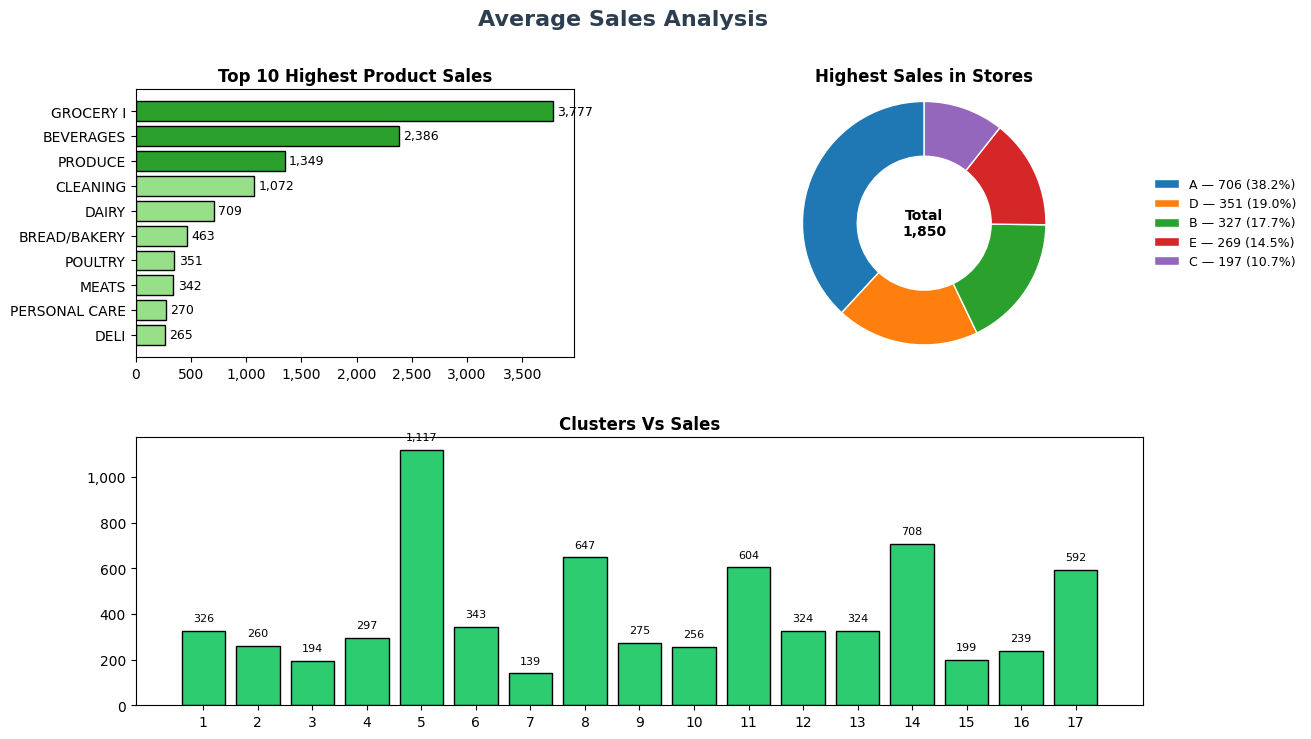

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import numpy as np

# Chu·∫©n ho√° t√™n c·ªôt ƒë·ªÉ code v·∫Ω d√πng chung 1 t√™n
df_fam_sales  = df_fam_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})
df_store_sales = df_store_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})
df_clus_sales  = df_clus_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})


# formatter: 1,234
fmt = FuncFormatter(lambda x, pos: f'{x:,.0f}')

fig = plt.figure(figsize=(13, 8))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# (1) Top 10 Highest Product Sales ‚Äî barh
ax1 = fig.add_subplot(gs[0, 0])
ax1.barh(df_fam_sales['family'], df_fam_sales['avg_sales_per_store_per_day'],
         color=['#2ca02c' if i < 3 else '#98df8a' for i in range(len(df_fam_sales))],
         edgecolor='black')
ax1.invert_yaxis()
ax1.set_title("Top 10 Highest Product Sales", fontsize=12, weight='bold')
ax1.xaxis.set_major_formatter(fmt)
for ylab, val in zip(df_fam_sales['family'], df_fam_sales['avg_sales_per_store_per_day']):
    ax1.text(val + max(df_fam_sales['avg_sales_per_store_per_day'])*0.01,
             ylab, f'{val:,.0f}', va='center', ha='left', fontsize=9, color='black')

# (2) Highest Sales in Stores ‚Äî donut with legend
ax2 = fig.add_subplot(gs[0, 1])
tmp = df_store_sales.sort_values('avg_sales_per_store_per_day', ascending=False).copy()
tmp.rename(columns={'avg_sales_per_store_per_day':'sales'}, inplace=True)
vals = tmp['sales'].to_numpy()
labels = tmp['store_type'].astype(str).to_numpy()
colors = plt.get_cmap('tab10').colors[:len(vals)]

wedges, _ = ax2.pie(
    vals, startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.45, edgecolor="white")
)
ax2.set_title("Highest Sales in Stores", fontsize=12, weight='bold')
ax2.axis('equal')

pct = vals / vals.sum() * 100
legend_labels = [f"{l} ‚Äî {v:,.0f} ({p:.1f}%)" for l, v, p in zip(labels, vals, pct)]
ax2.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=9)

ax2.text(0, 0, f"Total\n{vals.sum():,.0f}", ha='center', va='center', fontsize=10, weight='bold')

# (3) Clusters Vs Sales ‚Äî bar
ax3 = fig.add_subplot(gs[1, :])
x = df_clus_sales['cluster'].to_numpy()
y = df_clus_sales['avg_sales_per_store_per_day'].to_numpy()
ax3.bar(x, y, color='#2ecc71', edgecolor='black')
ax3.set_title("Clusters Vs Sales", fontsize=12, weight='bold')
ax3.set_xticks(x)
ax3.yaxis.set_major_formatter(fmt)
for xi, val in zip(x, y):
    ax3.text(xi, val + max(y)*0.03, f'{val:,.0f}', ha='center', va='bottom', fontsize=8, color='black')

fig.suptitle("Average Sales Analysis", fontsize=16, color='#2c3e50', weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


üéØ Tr·ª±c quan v·ªÅ bi·∫øn c·∫ßn d·ª± ƒëo√°n (df_fam_sales):
- Trung b√¨nh s·ªë l∆∞·ª£ng s·∫£n ph·∫©m b√°n ƒë∆∞·ª£c theo ng√†y v√† c·ª≠a h√†ng cho t·ª´ng nh√≥m h√†ng (family).

üìä Ph√¢n t√≠ch theo store_type (df_store_sales):
- Lo·∫°i c·ª≠a h√†ng kh√°c nhau c√≥ m·ª©c doanh s·ªë trung b√¨nh kh√°c nhau (·∫¢nh h∆∞·ªüng c·ªßa store_type)

üìä Ph√¢n t√≠ch theo cluster (df_clus_sales):
- C√°c c·ª•m th·ªã tr∆∞·ªùng (cluster) cho th·∫•y s·ª©c mua kh√°c nhau (·∫¢nh h∆∞·ªüng c·ªßa cluster)

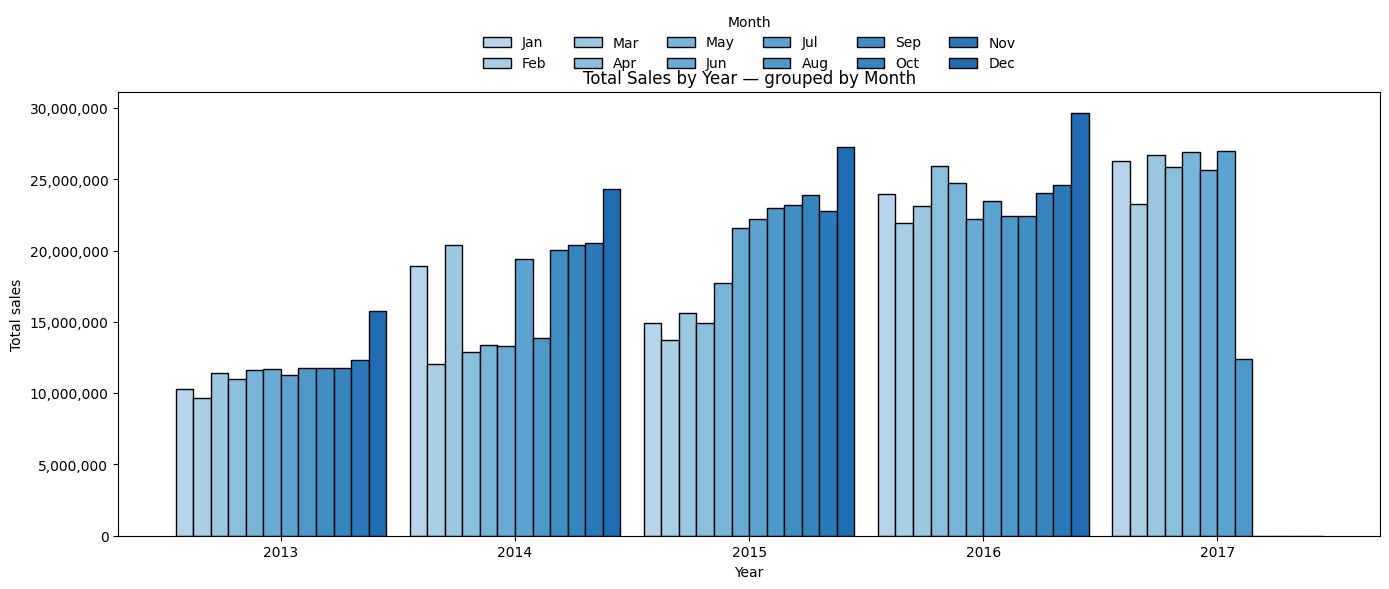

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import calendar

# === 1. Chu·∫©n b·ªã d·ªØ li·ªáu theo nƒÉm-th√°ng ===
df_year_month = (
    df_visualization
    .assign(year=df_visualization['date'].dt.year,
            month=df_visualization['date'].dt.month)
    .groupby(['year','month'], as_index=False)['sales'].sum()
)

# ƒë·∫£m b·∫£o ƒë·ªß 12 th√°ng m·ªói nƒÉm
years = np.sort(df_year_month['year'].unique())
months = np.arange(1, 13)

full_idx = pd.MultiIndex.from_product([years, months], names=['year','month'])
df_full = (df_year_month.set_index(['year','month'])
           .reindex(full_idx, fill_value=0)
           .reset_index())

# pivot: rows = year, cols = month
pv = df_full.pivot(index='year', columns='month', values='sales')

# === 2. V·∫Ω grouped bar v·ªõi c√πng 1 tone m√†u (Blues) ===
fmt = FuncFormatter(lambda x, pos: f'{x:,.0f}')

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(years))
n_m = len(months)
group_w = 0.9
bar_w = group_w / n_m
offsets = -group_w/2 + (np.arange(n_m) + 0.5) * bar_w

cmap = plt.get_cmap("Blues")
colors = [cmap(0.3 + 0.5*j/n_m) for j in range(n_m)]  # t·ª´ nh·∫°t t·ªõi ƒë·∫≠m

for j, m in enumerate(months):
    ax.bar(x + offsets[j],
           pv[m].to_numpy(),
           width=bar_w,
           label=calendar.month_abbr[m],
           color=colors[j],
           edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(years.astype(int))
ax.set_xlabel('Year')
ax.set_ylabel('Total sales')
ax.yaxis.set_major_formatter(fmt)
ax.set_title('Total Sales by Year ‚Äî grouped by Month')

ax.legend(title='Month', ncol=6, bbox_to_anchor=(0.5, 1.02),
          loc='lower center', frameon=False)

plt.tight_layout()
plt.show()


C·∫£m quan v·ªÅ ·∫£nh h∆∞·ªüng c·ªßa th·ªùi gian t·ªõi sales
- TƒÉng d·∫ßn theo nƒÉm
- Trong 1 nƒÉm th√¨ tƒÉng d·∫ßn v·ªÅ cu·ªëi nƒÉm

## 1.2. Ki·ªÉm tra ph√¢n ph·ªëi

- V·∫Ω bi·ªÉu ƒë·ªì gi√° tr·ªã theo th·ªùi gian (line plot) ƒë·ªÉ quan s√°t xu h∆∞·ªõng (trend) v√† t√≠nh m√πa v·ª• (seasonality).
- V·∫Ω histogram ƒë·ªÉ ki·ªÉm tra ph√¢n ph·ªëi c·ªßa gi√° tr·ªã numerical
- Ph√¢n t√≠ch c√°c ƒë·∫∑c ƒëi·ªÉm nh∆∞ t√≠nh d·ª´ng (stationarity) b·∫±ng c√°ch s·ª≠ d·ª•ng ki·ªÉm ƒë·ªãnh ADF (Augmented Dickey-Fuller) ho·∫∑c v·∫Ω ACF/PACF ƒë·ªÉ ki·ªÉm tra t·ª± t∆∞∆°ng quan.


In [39]:
# # Ph√¢n ph·ªëi c·ªßa c√°c bi·∫øn s·ªë sales, dcoilwtico, transactions, promotion
# import seaborn as sns
# import matplotlib.pyplot as plt

# cols = ['sales', 'dcoilwtico', 'transactions', 'onpromotion']

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, col in zip(axes.flat, cols):
#     sns.histplot(df_visualization[col].dropna(), bins=50, kde=True,
#                  color='#3498db', ax=ax)
#     ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
#     ax.set_xlabel(col)
#     ax.set_ylabel("Frequency")

# plt.tight_layout()
# plt.show()



In [40]:
df_visualization[['sales', 'dcoilwtico', 'transactions', 'onpromotion']].describe()


sales    dcoilwtico  transactions   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   3.577757e+02  6.792490e+01  1.555808e+03  2.602770e+00
std    1.101998e+03  2.566913e+01  1.033367e+03  1.221888e+01
min    0.000000e+00  2.619000e+01  0.000000e+00  0.000000e+00
25%    0.000000e+00  4.637750e+01  9.300000e+02  0.000000e+00
50%    1.100000e+01  5.341000e+01  1.331000e+03  0.000000e+00
75%    1.958473e+02  9.572000e+01  1.976250e+03  0.000000e+00
max    1.247170e+05  1.106200e+02  8.359000e+03  7.410000e+02

3 bi·∫øn sales, transactions, onpromotion: Ph√¢n ph·ªëi l·ªách ph·∫£i c·∫ßn log transform

RMSLE ƒë·ªãnh nghƒ©a r√µ: d√πng log(1+y)
N√™n target sales ph·∫£i bi·∫øn ƒë·ªïi b·∫±ng np.log1p(sales) ƒë·ªÉ nh·∫•t qu√°n v·ªõi loss.


Transactions, onpromotion (features): kh√¥ng b·∫Øt bu·ªôc, nh∆∞ng th∆∞·ªùng n√™n d√πng log1p thay v√¨ log ƒë·ªÉ an to√†n khi c√≥ 0

In [41]:
import numpy as np


# log1p cho c√°c bi·∫øn skew
df_visualization['sales']        = np.log1p(df_visualization['sales'])
df_visualization['transactions'] = np.log1p(df_visualization['transactions'])
df_visualization['onpromotion']  = np.log1p(df_visualization['onpromotion'])

print(df_visualization[['sales','transactions','onpromotion']].describe())


              sales  transactions   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.926368e+00  6.699789e+00  3.761500e-01
std    2.695122e+00  2.061778e+00  9.026737e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  6.836259e+00  0.000000e+00
50%    2.484907e+00  7.194437e+00  0.000000e+00
75%    5.282428e+00  7.589462e+00  0.000000e+00
max    1.173381e+01  9.031214e+00  6.609349e+00


In [42]:
# # Ph√¢n ph·ªëi c·ªßa c√°c bi·∫øn s·ªë sales, dcoilwtico, transactions, promotion sau log1p
# import seaborn as sns
# import matplotlib.pyplot as plt

# cols = ['sales', 'dcoilwtico', 'transactions', 'onpromotion']

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, col in zip(axes.flat, cols):
#     sns.histplot(df_visualization[col].dropna(), bins=50, kde=True,
#                  color='#3498db', ax=ax)
#     ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
#     ax.set_xlabel(col)
#     ax.set_ylabel("Frequency")

# plt.tight_layout()
# plt.show()


sales: gi·ªØ log l√†m target, kh√¥ng c·∫ßn scale th√™m.

transactions: log1p ‚Üí ph√¢n ph·ªëi ƒë·∫πp, scale StandardScaler.

onpromotion: log1p ‚Üí gi·∫£m skew, scale StandardScaler/RobustScaler.

dcoilwtico: kh√¥ng c·∫ßn log, ch·ªâ scale.

## 1.3. Th√™m feature is_earthquake
- Th√™m th√¥ng tin cho ng√†y 2016-04-16: tr·∫≠n ƒë·ªông ƒë·∫•t 7.8 ƒë·ªô Richter ·ªü Ecuador. 
- Trong data, ng√†y n√†y v√† m·ªôt s·ªë ng√†y ngay sau ƒë√≥ c√≥ bi·∫øn ƒë·ªông sales v√† transactions b·∫•t th∆∞·ªùng

In [43]:
# is_earthquake = 1 cho ng√†y 2016-04-16 v√† 1 tu·∫ßn sau ƒë√≥
start_eq = pd.to_datetime("2016-04-16")
end_eq   = pd.to_datetime("2016-04-22")

df_visualization['is_earthquake'] = (
    (df_visualization['date'] >= start_eq) &
    (df_visualization['date'] <= end_eq)
).astype('int8')

In [44]:
# ki·ªÉm tra nhanh
print(df_visualization.loc[
    (df_visualization['date'] >= "2016-04-15") &
    (df_visualization['date'] <= "2016-04-23"),
    ['date','store_nbr','family','sales','is_earthquake']
].head(10))

              date  store_nbr        family     sales  is_earthquake
2133054 2016-04-15          1    AUTOMOTIVE  1.791759              0
2133055 2016-04-15          1     BABY CARE  0.000000              0
2133056 2016-04-15          1        BEAUTY  1.609438              0
2133057 2016-04-15          1     BEVERAGES  7.605890              0
2133058 2016-04-15          1         BOOKS  0.000000              0
2133059 2016-04-15          1  BREAD/BAKERY  5.999472              0
2133060 2016-04-15          1   CELEBRATION  2.639057              0
2133061 2016-04-15          1      CLEANING  6.719013              0
2133062 2016-04-15          1         DAIRY  6.699500              0
2133063 2016-04-15          1          DELI  5.129123              0


## 1.4. Ph√¢n t√≠ch xu h∆∞·ªõng v√† m√πa v·ª•:


D√πng ACF/PACF ƒë·ªÉ x√°c ƒë·ªãnh chu k·ª≥ v√† t·ª± t∆∞∆°ng quan.


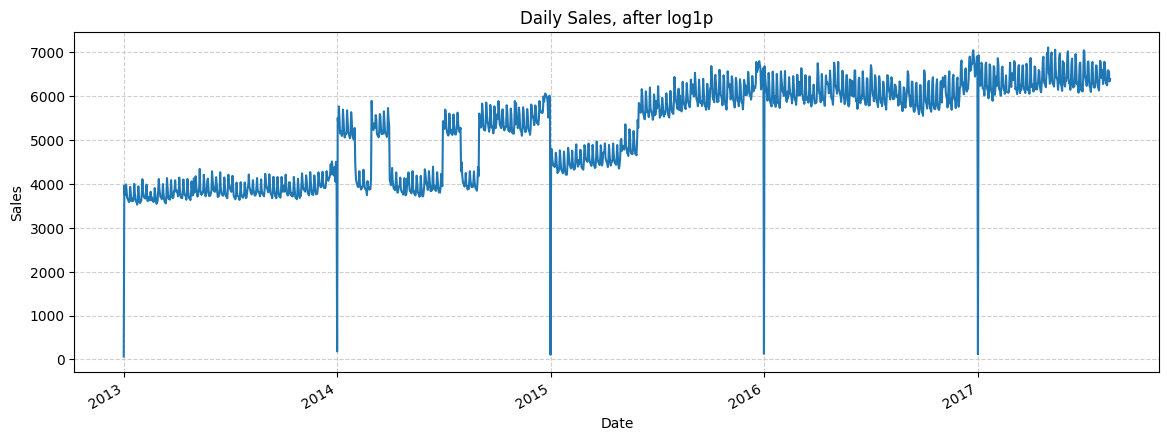

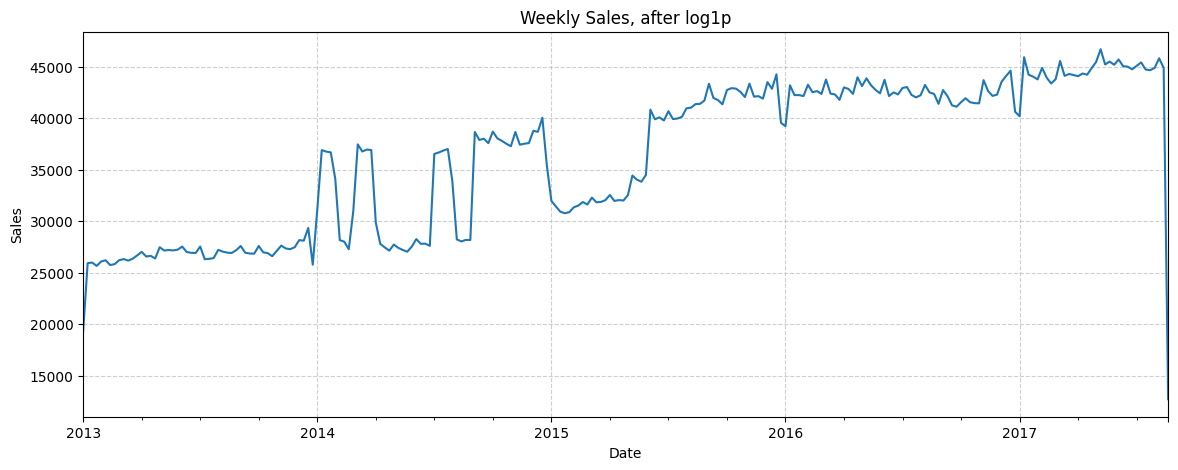

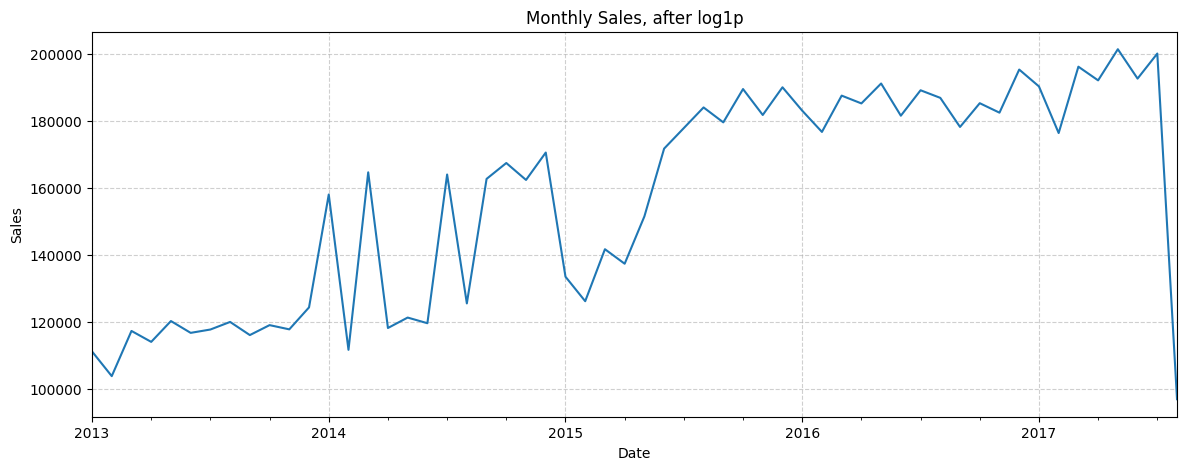

In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 5))
daily_sales = df_visualization.groupby('date')['sales'].sum()
daily_sales.plot(title="Daily Sales")
plt.title("Daily Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Theo tu·∫ßn
df_visualization.set_index('date')['sales'].resample('W').sum().plot(figsize=(14,5), title="Weekly Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Theo th√°ng
df_visualization.set_index('date')['sales'].resample('M').sum().plot(figsize=(14,5), title="Monthly Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [46]:
import numpy as np
import pandas as pd

# 1) Copy ƒë·ªÉ tr√°nh ghi ƒë√®
df_viz_copy = df_visualization.copy()

# 2) Kh√¥i ph·ª•c sales g·ªëc (v√¨ c·ªôt 'sales' ƒëang l√† log1p)
df_viz_copy['sales_original'] = np.expm1(df_viz_copy['sales'])

# 3) T·ªïng sales theo ng√†y (to√†n h·ªá th·ªëng)
daily_total = (
    df_viz_copy.groupby('date', as_index=False)['sales_original']
               .sum()
               .rename(columns={'sales_original': 'daily_sales_total'})
)

# 4) Trung b√¨nh sales theo ng√†y (overall)
avg_daily_total = daily_total['daily_sales_total'].mean()

# 5) L·∫•y 20 ng√†y c√≥ t·ªïng sales th·∫•p nh·∫•t (ch·ªâ gi·ªØ 2 c·ªôt)
lowest_20_days = daily_total.nsmallest(20, 'daily_sales_total')[["date", "daily_sales_total"]]

# In k·∫øt qu·∫£
print(f"Average daily total sales (original scale): {avg_daily_total:,.2f}")
print("\n20 ng√†y c√≥ t·ªïng sales th·∫•p nh·∫•t:")
print(lowest_20_days)


Average daily total sales (original scale): 637,556.38

20 ng√†y c√≥ t·ªïng sales th·∫•p nh·∫•t:
           date  daily_sales_total
0    2013-01-01        2511.618999
364  2014-01-01        8602.065404
1457 2017-01-01       12082.500997
728  2015-01-01       12773.616980
1092 2016-01-01       16433.394000
23   2013-01-24      247245.690995
72   2013-03-14      247541.420096
9    2013-01-10      258982.003049
28   2013-01-29      264488.818076
177  2013-06-27      266525.458966
16   2013-01-17      267498.515975
51   2013-02-21      267711.109015
114  2013-04-25      268790.618996
79   2013-03-21      269130.127953
56   2013-02-26      270425.007068
30   2013-01-31      271254.217996
70   2013-03-12      271823.378010
268  2013-09-26      273057.879859
84   2013-03-26      275818.235900
296  2013-10-24      276059.080003


C√°c ng√†y ƒë·∫ßu nƒÉm sales gi·∫£m m·∫°nh ƒë·ªôt ng·ªôt so v·ªõi trung b√¨nh
=> c·∫ßn t·∫°o bi·∫øn is_Newyear ƒë·ªÉ model ph√¢n bi·ªát t·ªët|

In [47]:
# T·∫°o c·ªôt is_Newyear: 1 n·∫øu ng√†y l√† 1/1, ng∆∞·ª£c l·∫°i 0
df_visualization['is_Newyear'] = (df_visualization['date'].dt.month.eq(1) & 
                                  df_visualization['date'].dt.day.eq(1)).astype(int)

# Ki·ªÉm tra nhanh
print(df_visualization[['date','is_Newyear']].drop_duplicates().query("is_Newyear == 1").head())


              date  is_Newyear
0       2013-01-01           1
648648  2014-01-01           1
1297296 2015-01-01           1
1945944 2016-01-01           1
2596374 2017-01-01           1


In [48]:
df_visualization[10000:10003]

date  store_nbr     family     sales  onpromotion  dcoilwtico  \
10000 2013-01-06          4  BABY CARE  0.000000          0.0       93.12   
10001 2013-01-06          4     BEAUTY  1.791759          0.0       93.12   
10002 2013-01-06          4  BEVERAGES  7.533694          0.0       93.12   

        city      state store_type  cluster  transactions  type_Additional  \
10000  Quito  Pichincha          D        9       7.54539                0   
10001  Quito  Pichincha          D        9       7.54539                0   
10002  Quito  Pichincha          D        9       7.54539                0   

       type_Bridge  type_Event  type_Holiday  type_Work Day  year  month  \
10000            0           0             0              0  2013      1   
10001            0           0             0              0  2013      1   
10002            0           0             0              0  2013      1   

       week  quarter  dow  dayofyear  is_weekend  is_15th  is_month_end  \
10000     1        1    6          6           1        0             0   
10001     1        1    6          6           1        0             0   
10002     1        1    6          6           1        0             0   

       is_earthquake  is_Newyear  
10000              0           0  
10001              0           0  
10002              0           0

In [49]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # V·∫Ω ACF v√† PACF cho sales
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot_acf(df_visualization['sales'], lags=40, ax=axes[0])
# axes[0].set_title("ACF - Autocorrelation Function (sales)")

# plot_pacf(df_visualization['sales'], lags=40, ax=axes[1], method='ywm')
# axes[1].set_title("PACF - Partial Autocorrelation Function (sales)")

# plt.tight_layout()
# plt.show()

In [50]:
# # t·ª± ƒë·ªông l·∫•y 200k ƒëi·ªÉm cu·ªëi r·ªìi v·∫Ω ACF/PACF
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # ==== c·∫•u h√¨nh nhanh ====
# MAX_N = 200_000      # s·ªë ƒëi·ªÉm t·ªëi ƒëa ƒë·ªÉ plot (an to√†n cho m√°y)
# LAGS  = 40           # s·ªë lag mu·ªën xem
# RESAMPLE = None      # None ho·∫∑c 'D' (ng√†y), 'W' (tu·∫ßn), 'M' (th√°ng)

# # ==== chu·∫©n b·ªã d·ªØ li·ªáu ====
# dfv = df_visualization.copy()
# dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')
# ser = dfv.set_index('date')['sales'].sort_index().astype('float').dropna()

# # (tu·ª≥ ch·ªçn) resample ƒë·ªÉ gi·∫£m nhi·ªÖu / gi·∫£m s·ªë ƒëi·ªÉm
# if RESAMPLE:
#     # v·ªõi sales th∆∞·ªùng h·ª£p l√Ω l√† sum theo k·ª≥
#     ser = ser.resample(RESAMPLE).sum().dropna()

# # c·∫Øt c√≤n MAX_N ƒëi·ªÉm cu·ªëi n·∫øu qu√° d√†i
# n = len(ser)
# if n > MAX_N:
#     ser = ser.iloc[-MAX_N:]
#     print(f"[Info] Chu·ªói g·ªëc c√≥ {n:,} ƒëi·ªÉm. ƒêang d√πng {len(ser):,} ƒëi·ªÉm cu·ªëi ƒë·ªÉ plot.")

# # ==== v·∫Ω ACF & PACF ====
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot_acf(ser, lags=LAGS, ax=axes[0])                      # ACF ‚Üí g·ª£i √Ω MA(q)
# axes[0].set_title(f"ACF (sales) - lags={LAGS}")

# # PACF ·ªïn ƒë·ªãnh v·ªõi method 'ywm' ho·∫∑c 'ywadjusted'
# plot_pacf(ser, lags=LAGS, ax=axes[1], method='ywm')       # PACF ‚Üí g·ª£i √Ω AR(p)
# axes[1].set_title(f"PACF (sales) - lags={LAGS}")

# plt.tight_layout()
# plt.show()


- ACF: cut off sau lag = 33 -> ch·ªçn l√†m sequence/lookback
- PACF: l·ªõn ·ªü lag = 7, 33 -> ch·ªçn l√†m lag features

# 2. Train test val split & T·∫°o Lag c·ªßa sales

## 2.1. T·∫°o lag features


In [51]:
import pandas as pd

dfv = df_visualization.copy()
dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')

# c·ªôt ƒë·ªãnh danh series ‚Äì ƒë·ªïi l·∫°i cho ƒë√∫ng t√™n c·ªôt c·ªßa b·∫°n
GROUP_COLS = ['store_nbr', 'family']      # v√≠ d·ª•

# sort theo nh√≥m + th·ªùi gian ƒë·ªÉ shift ƒë√∫ng
dfv = dfv.sort_values(GROUP_COLS + ['date']).reset_index(drop=True)

# t·∫°o lag theo t·ª´ng series
LAGS = [33, 7]   # th√™m 18, 24 n·∫øu mu·ªën
for k in LAGS:
    dfv[f'lag_{k}'] = dfv.groupby(GROUP_COLS)['sales'].shift(k)

# b·ªè h√†ng thi·∫øu do lag (b·ªã ·ªü ƒë·∫ßu m·ªói nh√≥m)
dfv = dfv.dropna(subset=[f'lag_{k}' for k in LAGS]).reset_index(drop=True)



In [52]:
dfv[-100010:-100000]

date  store_nbr        family     sales  onpromotion  \
2842072 2015-01-07         53  BREAD/BAKERY  5.856023     0.693147   
2842073 2015-01-08         53  BREAD/BAKERY  5.677743     1.386294   
2842074 2015-01-09         53  BREAD/BAKERY  5.830080     1.609438   
2842075 2015-01-10         53  BREAD/BAKERY  5.955420     0.693147   
2842076 2015-01-11         53  BREAD/BAKERY  6.495408     1.386294   
2842077 2015-01-12         53  BREAD/BAKERY  5.601333     0.000000   
2842078 2015-01-13         53  BREAD/BAKERY  5.537236     0.693147   
2842079 2015-01-14         53  BREAD/BAKERY  5.739455     1.098612   
2842080 2015-01-15         53  BREAD/BAKERY  5.891992     0.693147   
2842081 2015-01-16         53  BREAD/BAKERY  5.969620     1.791759   

         dcoilwtico   city   state store_type  cluster  transactions  \
2842072       48.69  Manta  Manabi          D       13      6.630683   
2842073       48.80  Manta  Manabi          D       13      6.556778   
2842074       48.35  Manta  Manabi          D       13      6.593045   
2842075       48.35  Manta  Manabi          D       13      6.795706   
2842076       48.35  Manta  Manabi          D       13      6.950815   
2842077       46.06  Manta  Manabi          D       13      6.577861   
2842078       45.92  Manta  Manabi          D       13      6.549651   
2842079       48.49  Manta  Manabi          D       13      6.594413   
2842080       46.37  Manta  Manabi          D       13      6.533789   
2842081       48.49  Manta  Manabi          D       13      6.736967   

         type_Additional  type_Bridge  type_Event  type_Holiday  \
2842072                0            0           0             0   
2842073                0            0           0             0   
2842074                0            0           0             0   
2842075                0            0           0             0   
2842076                0            0           0             0   
2842077                0            0           0             0   
2842078                0            0           0             0   
2842079                0            0           0             0   
2842080                0            0           0             0   
2842081                0            0           0             0   

         type_Work Day  year  month  week  quarter  dow  dayofyear  \
2842072              0  2015      1     2        1    2          7   
2842073              0  2015      1     2        1    3          8   
2842074              0  2015      1     2        1    4          9   
2842075              1  2015      1     2        1    5         10   
2842076              0  2015      1     2        1    6         11   
2842077              0  2015      1     3        1    0         12   
2842078              0  2015      1     3        1    1         13   
2842079              0  2015      1     3        1    2         14   
2842080              0  2015      1     3        1    3         15   
2842081              0  2015      1     3        1    4         16   

         is_weekend  is_15th  is_month_end  is_earthquake  is_Newyear  \
2842072           0        0             0              0           0   
2842073           0        0             0              0           0   
2842074           0        0             0              0           0   
2842075           1        0             0              0           0   
2842076           1        0             0              0           0   
2842077           0        0             0              0           0   
2842078           0        0             0              0           0   
2842079           0        0             0              0           0   
2842080           0        1             0              0           0   
2842081           0        0             0              0           0   

           lag_33     lag_7  
2842072  5.645797  6.619760  
2842073  5.823244  0.000000  
2842074  5.738148  6.131885  
2842075  6.182108

T·∫°o lag ƒë√∫ng theo t·ª´ng store - family

## 2.2. Chia TTV

In [53]:
import numpy as np
import pandas as pd

# 0) Chu·∫©n b·ªã
dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')
GROUP_COLS = ['store_nbr', 'family']  # ƒëi·ªÅu ch·ªânh cho ƒë√∫ng c·ªôt nh√≥m c·ªßa b·∫°n
dfv = dfv.sort_values(GROUP_COLS + ['date']).reset_index(drop=True)

# 1) Tham s·ªë ƒë·ªô d√†i theo NG√ÄY (calendar day)
TRAIN_DAYS = 90
VAL_DAYS   = 50
TEST1_DAYS = 40
TEST2_DAYS = 40

# N·∫øu mu·ªën ch·ªâ L·∫§Y ƒê√öNG 90 ng√†y cho train, ƒë·∫∑t False.
# M·∫∑c ƒë·ªãnh True = l·∫•y T·∫§T C·∫¢ ng√†y tr∆∞·ªõc m·ªëc val_start v√†o train (train >= 90)
include_all_prior_as_train = True

def assign_split_by_days(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('date').copy()
    # c√°c m·ªëc ng√†y duy nh·∫•t
    udates = (
        g['date']
        .dropna()
        .drop_duplicates()
        .sort_values()
        .to_list()
    )
    n_dates = len(udates)
    need = TRAIN_DAYS + VAL_DAYS + TEST1_DAYS + TEST2_DAYS

    # N·∫øu chu·ªói qu√° ng·∫Øn, fallback: ∆∞u ti√™n test2, test1, val; ph·∫ßn c√≤n l·∫°i l√† train
    if n_dates < need:
        # c·∫Øt t·ª´ cu·ªëi chu·ªói v·ªÅ tr∆∞·ªõc theo t·ªâ l·ªá y√™u c·∫ßu
        t2_len = min(TEST2_DAYS, n_dates)
        t2_start_idx = n_dates - t2_len
        t1_end_idx   = t2_start_idx
        t1_len = min(TEST1_DAYS, t1_end_idx)
        t1_start_idx = t1_end_idx - t1_len
        val_end_idx  = t1_start_idx
        v_len = min(VAL_DAYS, val_end_idx)
        v_start_idx = val_end_idx - v_len
        # train = ph·∫ßn c√≤n l·∫°i
        tr_start_idx = 0
        tr_end_idx   = v_start_idx

        t2_dates = set(udates[t2_start_idx : n_dates])
        t1_dates = set(udates[t1_start_idx : t1_end_idx])
        v_dates  = set(udates[v_start_idx  : val_end_idx])
        tr_dates = set(udates[tr_start_idx : tr_end_idx])

    else:
        # L·∫•y ƒë√∫ng c√°c c·ª≠a s·ªï t·ª´ CU·ªêI chu·ªói
        # test2: 40 ng√†y cu·ªëi
        t2_start_idx = n_dates - TEST2_DAYS
        t2_end_idx   = n_dates
        # test1: 40 ng√†y tr∆∞·ªõc test2
        t1_end_idx   = t2_start_idx
        t1_start_idx = t1_end_idx - TEST1_DAYS
        # val: 50 ng√†y tr∆∞·ªõc test1
        val_end_idx  = t1_start_idx
        val_start_idx= val_end_idx - VAL_DAYS
        # train:
        if include_all_prior_as_train:
            tr_start_idx = 0
        else:
            tr_start_idx = max(0, val_start_idx - TRAIN_DAYS)
        tr_end_idx = val_start_idx

        t2_dates = set(udates[t2_start_idx : t2_end_idx])
        t1_dates = set(udates[t1_start_idx : t1_end_idx])
        v_dates  = set(udates[val_start_idx: val_end_idx])
        tr_dates = set(udates[tr_start_idx : tr_end_idx])

    # g√°n nh√£n theo date
    conds = [
        g['date'].isin(tr_dates),
        g['date'].isin(v_dates),
        g['date'].isin(t1_dates),
        g['date'].isin(t2_dates),
    ]
    choices = ['train', 'val', 'test1', 'test2']
    g['split'] = np.select(conds, choices, default='ignore')

    return g

# 2) √Åp d·ª•ng theo t·ª´ng chu·ªói
dfv = dfv.groupby(GROUP_COLS, group_keys=False).apply(assign_split_by_days)

# 3) L·∫•y ra c√°c t·∫≠p
train_df = dfv[dfv['split'] == 'train'].copy()
val_df   = dfv[dfv['split'] == 'val'].copy()
test1_df = dfv[dfv['split'] == 'test1'].copy()
test2_df = dfv[dfv['split'] == 'test2'].copy()

print("Shapes:", train_df.shape, val_df.shape, test1_df.shape, test2_df.shape)

# 4) Ki·ªÉm tra min/max date theo t·ª´ng split (to√†n c·ª•c)
def show_range(name, d):
    if d.shape[0] == 0:
        print(f"{name:>6}: empty")
    else:
        print(f"{name:>6}: {pd.to_datetime(d['date']).min().date()}  ‚Üí  {pd.to_datetime(d['date']).max().date()}  (rows={len(d)})")


show_range("train", train_df)
show_range("val",   val_df)
show_range("test1", test1_df)
show_range("test2", test2_df)


Shapes: (2710422, 30) (89100, 30) (71280, 30) (71280, 30)
 train: 2013-02-03  ‚Üí  2017-04-07  (rows=2710422)
   val: 2017-04-08  ‚Üí  2017-05-27  (rows=89100)
 test1: 2017-05-28  ‚Üí  2017-07-06  (rows=71280)
 test2: 2017-07-07  ‚Üí  2017-08-15  (rows=71280)


- c·∫Øt theo t·ª´ng chu·ªói store_nbr‚Äìfamily, gi·ªØ ƒë√∫ng tr·∫≠t t·ª± th·ªùi gian: 90% ƒë·∫ßu = train, 50 ng√†y ti·∫øp = val, 40 ng√†y ti·∫øp = test1, test2 - m·ª•c ƒë√≠ch retrain l·∫°i model theo d·ªØ li·ªáu chu·ªói th·ªùi gian

In [54]:
# v√≠ d·ª• ch·ªçn 2 chu·ªói b·∫•t k·ª≥ ƒë·ªÉ ki·ªÉm tra
examples = [
    (1, 'BEVERAGES'),
    (2, 'BREAD/BAKERY')   # b·∫°n c√≥ th·ªÉ ƒë·ªïi sang family kh√°c trong dataset c·ªßa b·∫°n
]

SPLIT_ORDER = ['train', 'val', 'test1', 'test2']

for store, fam in examples:
    ex = dfv[(dfv['store_nbr'] == store) & (dfv['family'] == fam)].copy()
    ex['date'] = pd.to_datetime(ex['date'])
    ex['split'] = pd.Categorical(ex['split'], categories=SPLIT_ORDER, ordered=True)

    stats = (
        ex.groupby('split', observed=True)['date']
          .agg(min_date='min', max_date='max', row_count='count')
          .reset_index()
          .sort_values('split')
    )
    stats['unique_days'] = ex.groupby('split', observed=True)['date'].nunique().values

    print(f"\n=== Store {store} - Family {fam} ===")
    print(stats)



=== Store 1 - Family BEVERAGES ===
   split   min_date   max_date  row_count  unique_days
0  train 2013-02-03 2017-04-07       1521         1521
1    val 2017-04-08 2017-05-27         50           50
2  test1 2017-05-28 2017-07-06         40           40
3  test2 2017-07-07 2017-08-15         40           40

=== Store 2 - Family BREAD/BAKERY ===
   split   min_date   max_date  row_count  unique_days
0  train 2013-02-03 2017-04-07       1521         1521
1    val 2017-04-08 2017-05-27         50           50
2  test1 2017-05-28 2017-07-06         40           40
3  test2 2017-07-07 2017-08-15         40           40


In [55]:
# Drop c·ªôt 'split' kh·ªèi c√°c t·∫≠p 
train_df = train_df.drop(columns=['split'])
val_df   = val_df.drop(columns=['split'])
test1_df = test1_df.drop(columns=['split'])
test2_df = test2_df.drop(columns=['split'])


# 3. Preprocessing

C·∫ßn l∆∞u l·∫°i pipeline fit_transform train ƒë·ªÉ √°p d·ª•ng cho t·∫≠p val test

In [56]:
# Lo·∫°i b·ªè c·ªôt target tr∆∞·ªõc khi ph√¢n lo·∫°i features
target = 'sales'

# t·∫•t c·∫£ c·ªôt tr·ª´ target
features = [c for c in train_df.columns if c != target]

# categorical = object/string ho·∫∑c category dtype
cat_features = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

# numerical = number dtype (int, float)
num_features = train_df[features].select_dtypes(include=['number']).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)
# number of cat & num
print(len(cat_features), len(num_features))

Categorical features: ['family', 'city', 'state', 'store_type']
Numerical features: ['store_nbr', 'onpromotion', 'dcoilwtico', 'cluster', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'month', 'week', 'quarter', 'dow', 'dayofyear', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7']
4 23


ƒê·ªïi store_nbr, cluster th√†nh categorical

Embedding (static covariates): 
- C1: family, store_nbr, city, state, store_type, cluster (n·∫øu l√† ID).
- C2: embed family, store_nbr, city, state; PCA store_nbr, store_type, cluster -> 1 bi·∫øn numerical (B·ªé TRONG B√ÄI N·ªòP)

One-hot/binary gi·ªØ nguy√™n: is_weekend, is_15th, is_month_end, c√°c event types, is_earthquake

Scaled numerical: onpromotion, transactions, dcoilwtico, lag_33, lag_7

Cyclical encode: month, week, dow, dayofyear, quarter; year th√¨ k c·∫ßn cyclical encode

Drop: date (ƒë√£ drop ·ªü tr∆∞·ªõc)

In [57]:
train_df[cat_features].head()

family   city      state store_type
0  AUTOMOTIVE  Quito  Pichincha          D
1  AUTOMOTIVE  Quito  Pichincha          D
2  AUTOMOTIVE  Quito  Pichincha          D
3  AUTOMOTIVE  Quito  Pichincha          D
4  AUTOMOTIVE  Quito  Pichincha          D

In [58]:
train_df[num_features].head()

store_nbr  onpromotion  dcoilwtico  cluster  transactions  type_Additional  \
0          1          0.0       97.46       13      6.276643                0   
1          1          0.0       96.21       13      7.447168                0   
2          1          0.0       96.68       13      7.482119                0   
3          1          0.0       96.44       13      7.525101                0   
4          1          0.0       95.84       13      7.454720                0   

   type_Bridge  type_Event  type_Holiday  type_Work Day  year  month  week  \
0            0           0             0              0  2013      2     5   
1            0           0             0              0  2013      2     6   
2            0           0             0              0  2013      2     6   
3            0           0             0              0  2013      2     6   
4            0           0             0              0  2013      2     6   

   quarter  dow  dayofyear  is_weekend  is_15th  is_month_end  is_earthquake  \
0        1    6         34           1        0             0              0   
1        1    0         35           0        0             0              0   
2        1    1         36           0        0             0              0   
3        1    2         37           0        0             0              0   
4        1    3         38           0        0             0              0   

   is_Newyear    lag_33     lag_7  
0           0  0.000000  1.098612  
1           0  1.098612  1.386294  
2           0  1.386294  1.098612  
3           0  1.386294  1.945910  
4           0  1.791759  0.000000

- ƒê·ªïi store_nbr, cluster th√†nh categorical


In [59]:
train_df = train_df.copy()
train_df['store_nbr'] = train_df['store_nbr'].astype('category')
train_df['cluster']   = train_df['cluster'].astype('category')

print(train_df.dtypes[['store_nbr','cluster']])


store_nbr    category
cluster      category
dtype: object


-Train: 
- Cyclical encode: month, week, dow, dayofyear, quarter
- year th√¨ k c·∫ßn cyclical encode


In [60]:
import numpy as np

train_df = train_df.copy()

# h√†m encode tu·∫ßn ho√†n
def cyclical_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# encode cho c√°c bi·∫øn tu·∫ßn ho√†n
train_df = cyclical_encode(train_df, 'month', 12)
train_df = cyclical_encode(train_df, 'week', 52)        # ISO weeks
train_df = cyclical_encode(train_df, 'dow', 7)          # day of week
train_df = cyclical_encode(train_df, 'dayofyear', 365)  # day of year
train_df = cyclical_encode(train_df, 'quarter', 4)

# drop c√°c c·ªôt g·ªëc (tr·ª´ year gi·ªØ nguy√™n)
train_df = train_df.drop(columns=['month','week','dow','dayofyear','quarter'])


T∆∞∆°ng t·ª± cho val, test
- ƒê·ªïi store_nbr, cluster th√†nh categorical
- Cyclical encode: month, week, dow, dayofyear, quarter, year th√¨ k c·∫ßn cyclical encode


In [61]:
import numpy as np
import pandas as pd

# copy l·∫°i ƒë·ªÉ tr√°nh s·ª≠a nh·∫ßm
val_df   = val_df.copy()
test1_df = test1_df.copy()
test2_df = test2_df.copy()

# ==== 1) √âp dtype categorical cho cluster & store_nbr (val/test1/test2) ====
cat_cols = ['store_nbr', 'cluster']

# (khuy·∫øn ngh·ªã) n·∫øu c√≥ train_df, ƒë·ªìng b·ªô category theo train ƒë·ªÉ tr√°nh unseen codes
def to_category(df, cols, ref_df=None):
    for c in cols:
        df[c] = df[c].astype('category')
        if ref_df is not None and c in ref_df.columns:
            df[c] = df[c].cat.set_categories(pd.Categorical(ref_df[c]).categories)
    return df

# n·∫øu mu·ªën ƒë·ªìng b·ªô v·ªõi train: to_category(val_df, cat_cols, ref_df=train_df) ...
val_df   = to_category(val_df,   cat_cols)  # ho·∫∑c truy·ªÅn ref_df=train_df n·∫øu c√≥
test1_df = to_category(test1_df, cat_cols)  # ho·∫∑c truy·ªÅn ref_df=train_df n·∫øu c√≥
test2_df = to_category(test2_df, cat_cols)  # ho·∫∑c truy·ªÅn ref_df=train_df n·∫øu c√≥


# ==== 2) Cyclical encode cho c√°c bi·∫øn tu·∫ßn ho√†n ·ªü val/test1/test2 ====
def cyclical_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# n·∫øu b·∫°n d√πng isocalendar().week th√¨ c√≥ th·ªÉ c√≥ 53; dayofyear c√≥ th·ªÉ 366 (nƒÉm nhu·∫≠n)
cyc_features = {
    'month': 12,
    'week':  53,   # d√πng 53 an to√†n cho ISO week
    'dow':   7,
    'dayofyear': 366,  # an to√†n cho nƒÉm nhu·∫≠n
    'quarter': 4
}

for col, max_val in cyc_features.items():
    val_df   = cyclical_encode(val_df,   col, max_val)
    test1_df = cyclical_encode(test1_df, col, max_val)
    test2_df = cyclical_encode(test2_df, col, max_val)

# Drop c·ªôt g·ªëc cyclical (gi·ªØ year)
drop_cols = list(cyc_features.keys())
val_df   = val_df.drop(columns=drop_cols)
test1_df = test1_df.drop(columns=drop_cols)
test2_df = test2_df.drop(columns=drop_cols)



In [62]:
target = 'sales'

def list_features(df, target='sales'):
    # b·ªè target ra kh·ªèi t·∫≠p features
    features = [c for c in df.columns if c != target]
    
    cat_features = df[features].select_dtypes(include=['object','category']).columns.tolist()
    num_features = df[features].select_dtypes(include=['number']).columns.tolist()
    
    return cat_features, num_features

# Train
cat_features, num_features = list_features(train_df, target)
print("Train Categorical:", cat_features)
print("Train Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Val
cat_features, num_features = list_features(val_df, target)
print("\nVal Categorical:", cat_features)
print("Val Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Test1
cat_features, num_features = list_features(test1_df, target)
print("\nTest1 Categorical:", cat_features)
print("Test1 Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Test2
cat_features, num_features = list_features(test2_df, target)
print("\nTest2 Categorical:", cat_features)
print("Test2 Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))


Train Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Train Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos'] ... (total: 26 )
=> counts: 6 26

Val Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Val Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos'] ... (total: 26 )
=> counts: 6 26

Test1 Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Test1 Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_B

## 3.1. Bi·∫øn category

### 3.1.1. Encode

Khi b·∫°n ƒë·ªãnh d√πng embedding cho c√°c bi·∫øn categorical (store_nbr, family, city, state, store_type, cluster), th√¨ c√≥ v√†i y√™u c·∫ßu quan tr·ªçng:
- C√°c bi·∫øn n√†y ph·∫£i l√† discrete IDs (m√£ r·ªùi r·∫°c).

- Th∆∞·ªùng l√† integer kh√¥ng √¢m (0, 1, 2, ‚Ä¶, N-1).

- Kh√¥ng ƒë∆∞·ª£c chu·∫©n ho√° (MinMax/StandardScaler) v√¨ embedding lookup ch·ªâ l√†m vi·ªác v·ªõi index.

In [63]:
train_df[cat_features].head()

store_nbr      family   city      state store_type cluster
0         1  AUTOMOTIVE  Quito  Pichincha          D      13
1         1  AUTOMOTIVE  Quito  Pichincha          D      13
2         1  AUTOMOTIVE  Quito  Pichincha          D      13
3         1  AUTOMOTIVE  Quito  Pichincha          D      13
4         1  AUTOMOTIVE  Quito  Pichincha          D      13

1- Encode train + l∆∞u t·ª´ng encoder

In [64]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd, joblib

cat_features = ['store_nbr','family','city','state','store_type','cluster']

train_df = train_df.copy()

ord_encoders = {}
embed_dims   = {}

for col in cat_features:
    enc = OrdinalEncoder()
    enc.fit(train_df[[col]])
    train_df[f'{col}_idx'] = enc.transform(train_df[[col]]).astype('int32')
    
    ord_encoders[col] = enc
    embed_dims[col]   = int(len(enc.categories_[0]))

# drop c·ªôt g·ªëc
train_df.drop(columns=cat_features, inplace=True)

# l∆∞u encoder ƒë·ªÉ d√πng cho val/test
joblib.dump({'ord_encoders': ord_encoders, 'embed_dims': embed_dims},
            'ord_encoders_bundle.joblib')


print("Embedding input_dim:", embed_dims)


Embedding input_dim: {'store_nbr': 54, 'family': 33, 'city': 22, 'state': 16, 'store_type': 5, 'cluster': 17}


In [65]:
# Lo·∫°i b·ªè c·ªôt target tr∆∞·ªõc khi ph√¢n lo·∫°i features
target = 'sales'

# t·∫•t c·∫£ c·ªôt tr·ª´ target
features = [c for c in train_df.columns if c != target]

# categorical = object/string ho·∫∑c category dtype
cat_features = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

# numerical = number dtype (int, float)
num_features = train_df[features].select_dtypes(include=['number']).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)
# number of cat & num
print(len(cat_features), len(num_features))

Categorical features: []
Numerical features: ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'dow_sin', 'dow_cos', 'dayofyear_sin', 'dayofyear_cos', 'quarter_sin', 'quarter_cos', 'store_nbr_idx', 'family_idx', 'city_idx', 'state_idx', 'store_type_idx', 'cluster_idx']
0 32


In [66]:
# IN RA C√ÅC C·ªòT ƒê√É ENCODE XONG

train_df.iloc[:5, -5:]

family_idx  city_idx  state_idx  store_type_idx  cluster_idx
0           0        18         12               3           12
1           0        18         12               3           12
2           0        18         12               3           12
3           0        18         12               3           12
4           0        18         12               3           12

2- Encode val b·∫±ng encoder ƒë√£ l∆∞u

In [67]:
import joblib
val_df = val_df.copy()

# load encoders ƒë√£ fit t·ª´ train
bundle = joblib.load('ord_encoders_bundle.joblib')
ord_encoders = bundle['ord_encoders']

# danh s√°ch c·ªôt g·ªëc categorical ƒë√£ fit encoder
orig_cat_features = ['store_nbr','family','city','state','store_type','cluster']

# encode categorical features (d√πng encoder ƒë√£ fit t·ª´ train)
for col in orig_cat_features:
    enc = ord_encoders[col]
    val_df[f'{col}_idx'] = enc.transform(val_df[[col]]).astype('int32')

# drop c·ªôt g·ªëc
val_df.drop(columns=orig_cat_features, inplace=True)


3- Encode test b·∫±ng encoder ƒë√£ l∆∞u

In [68]:
# danh s√°ch c·ªôt g·ªëc categorical ƒë√£ fit encoder
orig_cat_features = ['store_nbr','family','city','state','store_type','cluster']

# copy ƒë·ªÉ tr√°nh s·ª≠a nh·∫ßm
test1_df = test1_df.copy()
test2_df = test2_df.copy()

# encode categorical features (d√πng encoder ƒë√£ fit t·ª´ train)
for col in orig_cat_features:
    enc = ord_encoders[col]
    test1_df[f'{col}_idx'] = enc.transform(test1_df[[col]]).astype('int32')
    test2_df[f'{col}_idx'] = enc.transform(test2_df[[col]]).astype('int32')

# drop c·ªôt g·ªëc
test1_df.drop(columns=orig_cat_features, inplace=True)
test2_df.drop(columns=orig_cat_features, inplace=True)


In [69]:
train_df.head()

date     sales  onpromotion  dcoilwtico  transactions  \
0 2013-02-03  0.000000          0.0       97.46      6.276643   
1 2013-02-04  1.791759          0.0       96.21      7.447168   
2 2013-02-05  0.000000          0.0       96.68      7.482119   
3 2013-02-06  0.693147          0.0       96.44      7.525101   
4 2013-02-07  0.693147          0.0       95.84      7.454720   

   type_Additional  type_Bridge  type_Event  type_Holiday  type_Work Day  \
0                0            0           0             0              0   
1                0            0           0             0              0   
2                0            0           0             0              0   
3                0            0           0             0              0   
4                0            0           0             0              0   

   year  is_weekend  is_15th  is_month_end  is_earthquake  is_Newyear  \
0  2013           1        0             0              0           0   
1  2013           0        0             0              0           0   
2  2013           0        0             0              0           0   
3  2013           0        0             0              0           0   
4  2013           0        0             0              0           0   

     lag_33     lag_7  month_sin  month_cos  week_sin  week_cos   dow_sin  \
0  0.000000  1.098612   0.866025        0.5  0.568065  0.822984 -0.781831   
1  1.098612  1.386294   0.866025        0.5  0.663123  0.748511  0.000000   
2  1.386294  1.098612   0.866025        0.5  0.663123  0.748511  0.781831   
3  1.386294  1.945910   0.866025        0.5  0.663123  0.748511  0.974928   
4  1.791759  0.000000   0.866025        0.5  0.663123  0.748511  0.433884   

    dow_cos  dayofyear_sin  dayofyear_cos  quarter_sin   quarter_cos  \
0  0.623490       0.552435       0.833556          1.0  6.123234e-17   
1  1.000000       0.566702       0.823923          1.0  6.123234e-17   
2  0.623490       0.580800       0.814046          1.0  6.123234e-17   
3 -0.222521       0.594727       0.803928          1.0  6.123234e-17   
4 -0.900969       0.608477       0.793572          1.0  6.123234e-17   

   store_nbr_idx  family_idx  city_idx  state_idx  store_type_idx  cluster_idx  
0              0           0        18         12               3           12  
1              0           0        18         12               3           12  
2              0           0        18         12               3           12  
3              0           0        18         12               3           12  
4              0           0        18         12               3           12

In [70]:
test1_df.head()

date     sales  onpromotion  dcoilwtico  transactions  \
1571 2017-05-28  1.098612          0.0       49.58      6.240276   
1572 2017-05-29  1.945910          0.0       49.58      7.467942   
1573 2017-05-30  1.098612          0.0       49.63      7.479300   
1574 2017-05-31  1.386294          0.0       48.29      7.538495   
1575 2017-06-01  1.945910          0.0       48.32      7.504392   

      type_Additional  type_Bridge  type_Event  type_Holiday  type_Work Day  \
1571                0            0           0             0              0   
1572                0            0           0             0              0   
1573                0            0           0             0              0   
1574                0            0           0             0              0   
1575                0            0           0             0              0   

      year  is_weekend  is_15th  is_month_end  is_earthquake  is_Newyear  \
1571  2017           1        0             0              0           0   
1572  2017           0        0             0              0           0   
1573  2017           0        0             0              0           0   
1574  2017           0        0             1              0           0   
1575  2017           0        0             0              0           0   

        lag_33     lag_7     month_sin  month_cos  week_sin  week_cos  \
1571  1.386294  0.693147  5.000000e-01  -0.866025    0.6068 -0.794854   
1572  1.098612  1.098612  5.000000e-01  -0.866025  0.508531 -0.861044   
1573  2.197225  1.609438  5.000000e-01  -0.866025  0.508531 -0.861044   
1574  1.386294  2.079442  5.000000e-01  -0.866025  0.508531 -0.861044   
1575  1.098612  1.098612  1.224647e-16  -1.000000  0.508531 -0.861044   

       dow_sin   dow_cos  dayofyear_sin  dayofyear_cos   quarter_sin  \
1571 -0.781831  0.623490       0.565345      -0.824855  1.224647e-16   
1572  0.000000  1.000000       0.551102      -0.834438  1.224647e-16   
1573  0.781831  0.623490       0.536696      -0.843776  1.224647e-16   
1574  0.974928 -0.222521       0.522133      -0.852864  1.224647e-16   
1575  0.433884 -0.900969       0.507415      -0.861702  1.224647e-16   

      quarter_cos  store_nbr_idx  family_idx  city_idx  state_idx  \
1571         -1.0              0           0        18         12   
1572         -1.0              0           0        18         12   
1573         -1.0              0           0        18         12   
1574         -1.0              0           0        18         12   
1575         -1.0              0           0        18         12   

      store_type_idx  cluster_idx  
1571               3           12  
1572               3           12  
1573               3           12  
1574               3           12  
1575               3           12

In [71]:
col = "family"
enc = ord_encoders[col]

print(f"=== Full encode/decode mapping for '{col}' ===")

# --- Train ---
train_map = (
    train_df.groupby(f"{col}_idx")
            .size()
            .reset_index(name="count")
)
train_map["decode"] = enc.inverse_transform(train_map[[f"{col}_idx"]]).ravel()
print("\nTrain mapping:")
print(train_map.head(20))  # ho·∫∑c b·ªè head() ƒë·ªÉ in h·∫øt

# --- Test1 ---
test1_map = (
    test1_df.groupby(f"{col}_idx")
            .size()
            .reset_index(name="count")
)
test1_map["decode"] = enc.inverse_transform(test1_map[[f"{col}_idx"]]).ravel()
print("\nTest1 mapping:")
print(test1_map.head(20))


=== Full encode/decode mapping for 'family' ===

Train mapping:
    family_idx  count               decode
0            0  82134           AUTOMOTIVE
1            1  82134            BABY CARE
2            2  82134               BEAUTY
3            3  82134            BEVERAGES
4            4  82134                BOOKS
5            5  82134         BREAD/BAKERY
6            6  82134          CELEBRATION
7            7  82134             CLEANING
8            8  82134                DAIRY
9            9  82134                 DELI
10          10  82134                 EGGS
11          11  82134         FROZEN FOODS
12          12  82134            GROCERY I
13          13  82134           GROCERY II
14          14  82134             HARDWARE
15          15  82134   HOME AND KITCHEN I
16          16  82134  HOME AND KITCHEN II
17          17  82134      HOME APPLIANCES
18          18  82134            HOME CARE
19          19  82134           LADIESWEAR

Test1 mapping:
    family_idx  c

## 3.2. Bi·∫øn numerical

- Ki·ªÉm tra ph√¢n ph·ªëi trc khi Scale

In [72]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# features_to_check = ['onpromotion', 'transactions', 'dcoilwtico', 'lag_33', 'lag_7']

# # copy v√† g·∫Øn nh√£n dataset
# train_tmp  = train_df.copy();  train_tmp['dataset']  = 'train'
# val_tmp    = val_df.copy();    val_tmp['dataset']    = 'val'
# test1_tmp  = test1_df.copy();  test1_tmp['dataset']  = 'test1'
# test2_tmp  = test2_df.copy();  test2_tmp['dataset']  = 'test2'

# # g·ªôp l·∫°i
# df_check = pd.concat([
#     train_tmp[features_to_check + ['dataset']],
#     val_tmp[features_to_check + ['dataset']],
#     test1_tmp[features_to_check + ['dataset']],
#     test2_tmp[features_to_check + ['dataset']]
# ])

# # v·∫Ω histogram cho t·ª´ng feature
# for col in features_to_check:
#     plt.figure(figsize=(8,4))
#     sns.histplot(data=df_check, x=col, hue='dataset',
#                  element="step", stat="density", common_norm=False)
#     plt.title(f"Distribution of {col} across train/val/test1/test2")
#     plt.show()


- Ph√¢n ph·ªëi Train-Val-Test c·ªßa c√°c bi·∫øn ƒë·ªÅu h·ª£p l·ªá ƒë·ªÉ Standard Scaler

### 3.2.1. Normalize/scale


- Bi·∫øn target: sales
- Kh√¥ng n√™n Scale ƒë·ªÉ c√≤n predict

- Bi·∫øn year, onpromotion, transactions, dcoilwtico, lag_33, lag_7: ch∆∞a scale

In [73]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 0) C·∫•u h√¨nh
scale_cols = ['year', 'onpromotion', 'transactions', 'dcoilwtico', 'lag_33', 'lag_7']

# B·∫£o to√†n b·∫£n g·ªëc n·∫øu c·∫ßn
train_df  = train_df.copy()
val_df    = val_df.copy()
test1_df  = test1_df.copy()
test2_df  = test2_df.copy()

# 1) Fit scaler tr√™n TRAIN
scaler = StandardScaler()
scaler.fit(train_df[scale_cols])


StandardScaler()

In [74]:
# 2) Transform TRAIN/VAL/TEST1/TEST2
def add_scaled_and_drop(df, cols, scaler, suffix='_sc'):
    Xs = scaler.transform(df[cols])
    Xs = pd.DataFrame(Xs, columns=[c+suffix for c in cols], index=df.index)
    out = pd.concat([df.drop(columns=cols), Xs], axis=1)
    return out

train_df  = add_scaled_and_drop(train_df,  scale_cols, scaler)
val_df    = add_scaled_and_drop(val_df,    scale_cols, scaler)
test1_df  = add_scaled_and_drop(test1_df,  scale_cols, scaler)
test2_df  = add_scaled_and_drop(test2_df,  scale_cols, scaler)


In [75]:
# 3) Ki·ªÉm tra l·∫°i
sc_cols_sc = [c + '_sc' for c in scale_cols]

print("Scaled columns added:", sc_cols_sc)
print("Shapes:",
      "train", train_df.shape,
      "val",   val_df.shape,
      "test1", test1_df.shape,
      "test2", test2_df.shape)

# Ki·ªÉm tra mean‚âà0, std‚âà1 tr√™n TRAIN cho c√°c c·ªôt ƒë√£ scale
print("\nTRAIN scaled means (‚âà0):")
print(train_df[sc_cols_sc].mean().round(4))
print("\nTRAIN scaled stds (‚âà1):")
print(train_df[sc_cols_sc].std(ddof=0).round(4))  # ddof=0 ƒë·ªÉ kh·ªõp chu·∫©n h√≥a c·ªßa StandardScaler

# Ki·ªÉm tra NaN sau khi scale
print("\nNaN counts after scaling (should be 0):")
print("train:", train_df[sc_cols_sc].isna().sum().sum(),
      "val:",   val_df[sc_cols_sc].isna().sum().sum(),
      "test1:", test1_df[sc_cols_sc].isna().sum().sum(),
      "test2:", test2_df[sc_cols_sc].isna().sum().sum())


Scaled columns added: ['year_sc', 'onpromotion_sc', 'transactions_sc', 'dcoilwtico_sc', 'lag_33_sc', 'lag_7_sc']
Shapes: train (2710422, 34) val (89100, 34) test1 (71280, 34) test2 (71280, 34)

TRAIN scaled means (‚âà0):
year_sc            0.0
onpromotion_sc     0.0
transactions_sc   -0.0
dcoilwtico_sc     -0.0
lag_33_sc         -0.0
lag_7_sc          -0.0
dtype: float64

TRAIN scaled stds (‚âà1):
year_sc            1.0
onpromotion_sc     1.0
transactions_sc    1.0
dcoilwtico_sc      1.0
lag_33_sc          1.0
lag_7_sc           1.0
dtype: float64

NaN counts after scaling (should be 0):
train: 0 val: 0 test1: 0 test2: 0


# 4. TENSORFLOW LSTM MODEL & TRAINING

Sau khi preprocessing ho√†n t·∫•t, ch√∫ng ta s·∫Ω x√¢y d·ª±ng LSTM model b·∫±ng TensorFlow ƒë·ªÉ d·ª± ƒëo√°n sales.

## T·ªïng quan:
- ‚úÖ **Framework**: TensorFlow v·ªõi GPU support  
- ‚úÖ **Architecture**: LSTM v·ªõi Layer Normalization
- ‚úÖ **Input**: Sequence length = 33 ng√†y
- ‚úÖ **Output**: D·ª± ƒëo√°n sales cho ng√†y ti·∫øp theo
- ‚úÖ **Target**: log1p(sales) ƒë·ªÉ t∆∞∆°ng th√≠ch RMSLE loss

In [76]:
# 4.1. TensorFlow Setup & Constants

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# GPU Setup
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Enable memory growth ƒë·ªÉ tr√°nh chi·∫øm tr·ªçn VRAM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("‚úÖ GPU memory growth enabled")
    except RuntimeError as e:
        print("‚ö†Ô∏è Memory growth setting failed:", e)

# Mixed precision ƒë·ªÉ tƒÉng t·ªëc ƒë·ªô training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("‚úÖ Mixed precision enabled")

# Constants
SEQ_LEN = 33
FEATURES = [
 'type_Additional','type_Bridge','type_Event','type_Holiday','type_Work Day',
 'is_weekend','is_15th','is_month_end','is_earthquake','is_Newyear',
 'month_sin','month_cos','week_sin','week_cos','dow_sin','dow_cos',
 'dayofyear_sin','dayofyear_cos','quarter_sin','quarter_cos',
 'store_nbr_idx','family_idx','city_idx','state_idx','store_type_idx','cluster_idx',
 'year_sc','onpromotion_sc','transactions_sc','dcoilwtico_sc','lag_33_sc','lag_7_sc'
]
TARGET = 'sales'
STORE_COL, FAMILY_COL, DATE_COL = 'store_nbr_idx', 'family_idx', 'date'
N_FEAT = len(FEATURES)  # d√πng cho TensorSpec

print(f"‚úÖ Sequence length: {SEQ_LEN}")
print(f"‚úÖ Number of features: {len(FEATURES)}")
print(f"‚úÖ Target: {TARGET} (log1p transformed)")

TensorFlow version: 2.20.0
GPU available: []
‚úÖ Mixed precision enabled
‚úÖ Sequence length: 33
‚úÖ Number of features: 32
‚úÖ Target: sales (log1p transformed)


In [77]:
# 4.2. Data Preparation for TensorFlow



In [78]:
# ---------- UTILS ----------
def get_series_keys(df, store_col=STORE_COL, family_col=FAMILY_COL):
    keys = (df[[store_col, family_col]]
            .drop_duplicates()
            .sort_values([store_col, family_col]))
    return list(map(tuple, keys.values.tolist()))

def _to_np(df, feature_cols, target_col):
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df[target_col].to_numpy(dtype=np.float32)
    return X, y

def _yield_windows_from_sorted_frame(g_df, feature_cols, target_col, seq_len):
    """g_df ƒë√£ sort theo DATE_COL v√† thu·ªôc 1 series ‚Üí yield (x_win, y_t, date_t)."""
    if len(g_df) <= seq_len:
        return
    X, y = _to_np(g_df, feature_cols, target_col)
    dates = g_df[DATE_COL].to_numpy()
    for t in range(seq_len, len(g_df)):
        xw = X[t-seq_len:t, :]   # (T, F)
        yt = y[t]                # ()
        dt = dates[t]
        yield xw, yt, dt

In [79]:
# ---------- GENERATORS ----------
def train_window_generator(train_df, feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """Yield (x, y) theo ƒë√∫ng th·ª© t·ª± th·ªùi gian, kh√¥ng r√≤ r·ªâ val."""
    for s_id, f_id in get_series_keys(train_df, STORE_COL, FAMILY_COL):
        g_tr = (train_df[(train_df[STORE_COL]==s_id) & (train_df[FAMILY_COL]==f_id)]
                .sort_values(DATE_COL).reset_index(drop=True))
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_tr, feature_cols, target_col, seq_len):
            yield (xw.astype(np.float32), np.float32(yt))

def val_window_generator(train_df, val_df, feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """M·ªói series: n·ªëi tail(seq_len) c·ªßa train + full val ‚Üí c·∫Øt c·ª≠a s·ªï; ch·ªâ tr·∫£ ƒë√∫ng s·ªë ƒëi·ªÉm c·ªßa val."""
    val_keys = get_series_keys(val_df, STORE_COL, FAMILY_COL)
    keys = val_keys if len(val_keys) > 0 else get_series_keys(train_df, STORE_COL, FAMILY_COL)

    for s_id, f_id in keys:
        g_tr = (train_df[(train_df[STORE_COL]==s_id) & (train_df[FAMILY_COL]==f_id)]
                .sort_values(DATE_COL).reset_index(drop=True))
        g_val = (val_df[(val_df[STORE_COL]==s_id) & (val_df[FAMILY_COL]==f_id)]
                 .sort_values(DATE_COL).reset_index(drop=True))
        if len(g_tr) < seq_len or len(g_val) == 0:
            continue
        g_ctx = pd.concat([g_tr.tail(seq_len), g_val], ignore_index=True)

        # c·∫Øt c·ª≠a s·ªï tr√™n [context + val]
        total = 0
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_ctx, feature_cols, target_col, seq_len):
            total += 1
            # ch·ªâ l·∫•y ƒë√∫ng s·ªë h√†ng c·ªßa val (b·ªè ph·∫ßn context)
            if total > len(g_val):
                break
            yield (xw.astype(np.float32), np.float32(yt))



In [80]:
# ---------- TF.DATA BUILDERS ----------
def make_tf_dataset_train(train_df, batch_size=64, shuffle=False, buffer_size=8192):
    ds = tf.data.Dataset.from_generator(
        lambda: train_window_generator(train_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def make_tf_dataset_val(train_df, val_df, batch_size=64):
    ds = tf.data.Dataset.from_generator(
        lambda: val_window_generator(train_df, val_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [72]:

# ---------- USAGE ----------
# train_df, val_df ph·∫£i l√† Pandas DataFrame ƒë√£ c√≥ c√°c c·ªôt FEATURES + TARGET + date/store/family
# V√≠ d·ª•:
# train_ds = make_tf_dataset_train(train_df, batch_size=64, shuffle=False)
# val_ds   = make_tf_dataset_val(train_df, val_df, batch_size=64)
# model.fit(train_ds, validation_data=val_ds, epochs=..., callbacks=...)

In [ ]:
# # 4.3. TensorFlow LSTM Model Definition

# def create_lstm_model(n_features, config):
#     """
#     T·∫°o LSTM model v·ªõi TensorFlow/Keras
    
#     Args:
#         n_features: S·ªë l∆∞·ª£ng features
#         config: Dictionary ch·ª©a hyperparameters
#     """
#     model = Sequential(name='LSTM_Sales_Forecasting')
    
#     # Input projection layer (optional)
#     if config.get('use_input_projection', True):
#         model.add(Dense(
#             config['hidden_units'], 
#             activation='relu',
#             input_shape=(config['sequence_length'], n_features),
#             name='input_projection'
#         ))
        
#         # Layer normalization sau input projection
#         if config.get('use_layer_norm', True):
#             model.add(LayerNormalization(name='input_layer_norm'))
    
#     # LSTM layers
#     for i in range(config['num_lstm_layers']):
#         return_sequences = (i < config['num_lstm_layers'] - 1)  # True cho layers trung gian
        
#         model.add(LSTM(
#             config['hidden_units'],
#             return_sequences=return_sequences,
#             dropout=config.get('lstm_dropout', 0.0),
#             recurrent_dropout=config.get('recurrent_dropout', 0.0),
#             name=f'lstm_layer_{i+1}'
#         ))
        
#         # Layer normalization sau m·ªói LSTM
#         if config.get('use_layer_norm', True) and not return_sequences:
#             model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}'))
    
#     # Output layers
#     if config.get('use_dense_layers', True):
#         # Dense layer v·ªõi dropout
#         model.add(Dense(
#             config['hidden_units'] // 2, 
#             activation='relu',
#             name='dense_hidden'
#         ))
#         model.add(Dropout(config.get('dense_dropout', 0.2), name='dense_dropout'))
    
#     # Final output layer (regression)
#     model.add(Dense(1, activation='linear', name='output', dtype='float32'))
    
#     return model

# # Default configuration
# DEFAULT_CONFIG = {
#     'sequence_length': 33,
#     'hidden_units': 128,
#     'num_lstm_layers': 2,
#     'lstm_dropout': 0.2,
#     'recurrent_dropout': 0.0,
#     'dense_dropout': 0.2,
#     'use_input_projection': True,
#     'use_layer_norm': True,
#     'use_dense_layers': True,
    
#     # Training parameters
#     'learning_rate': 5e-4,
#     'batch_size': 256,
#     'epochs': 50,
#     'patience': 8,
#     'reduce_lr_patience': 3,
#     'reduce_lr_factor': 0.7,
#     'min_lr': 1e-6
# }

# print("‚úÖ LSTM model builder defined")
# print("üìù Default config:")
# for key, value in DEFAULT_CONFIG.items():
#     print(f"   {key:20}: {value}")
    
# print("\nüìù Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)")

‚úÖ LSTM model builder defined
üìù Default config:
   sequence_length     : 33
   hidden_units        : 128
   num_lstm_layers     : 2
   lstm_dropout        : 0.2
   recurrent_dropout   : 0.0
   dense_dropout       : 0.2
   use_input_projection: True
   use_layer_norm      : True
   use_dense_layers    : True
   learning_rate       : 0.0005
   batch_size          : 256
   epochs              : 50
   patience            : 8
   reduce_lr_patience  : 3
   reduce_lr_factor    : 0.7
   min_lr              : 1e-06

üìù Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)


In [89]:
# 4.3. TensorFlow LSTM Model Definition

def create_lstm_model(n_features, config):
    model = Sequential(name='LSTM_Sales_Forecasting')
    
    # Input projection
    if config.get('use_input_projection', True):
        model.add(Dense(
            config['hidden_units'], 
            activation='relu',
            input_shape=(config['sequence_length'], n_features),
            name='input_projection'
        ))
        if config.get('use_layer_norm', True):
            model.add(LayerNormalization(name='input_layer_norm'))
    
    # LSTM stack
    for i in range(config['num_lstm_layers']):
        is_last = (i == config['num_lstm_layers'] - 1)
        return_sequences = not is_last
        
        model.add(LSTM(
            config['hidden_units'],
            return_sequences=return_sequences,
            dropout=config.get('lstm_dropout', 0.0),
            recurrent_dropout=config.get('recurrent_dropout', 0.0),
            name=f'lstm_layer_{i+1}'
        ))
        
        # --- NEW: LayerNorm gi·ªØa c√°c LSTM ---
        if (
            config.get('use_layer_norm', True)
            and config.get('layer_norm_between_lstm', True)  # b·∫≠t/t·∫Øt nhanh
            and return_sequences  # ch·ªâ gi·ªØa c√°c LSTM
        ):
            model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}_between'))
        
        # (tu·ª≥ ch·ªçn) LayerNorm sau LSTM cu·ªëi:
        if (
            config.get('use_layer_norm', True)
            and config.get('layer_norm_after_last_lstm', True)
            and not return_sequences
        ):
            model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}'))

    # Dense head
    if config.get('use_dense_layers', True):
        model.add(Dense(
            config['hidden_units'] // 2, 
            activation='relu',
            name='dense_hidden'
        ))
        model.add(Dropout(config.get('dense_dropout', 0.2), name='dense_dropout'))
    
    model.add(Dense(1, activation='linear', name='output', dtype='float32'))
    return model

# Default configuration
DEFAULT_CONFIG = {
    'sequence_length': 33,
    'hidden_units': 128,
    'num_lstm_layers': 2,
    'lstm_dropout': 0.2,
    'recurrent_dropout': 0.0,
    'dense_dropout': 0.2,
    'use_input_projection': True,
    'use_layer_norm': True,
    'use_dense_layers': True,

    # NEW toggles
    'layer_norm_between_lstm': True,         # th√™m LN gi·ªØa c√°c LSTM
    'layer_norm_after_last_lstm': True,      # gi·ªØ LN sau LSTM cu·ªëi (c√≥ th·ªÉ ƒë·∫∑t False)

    # Training
    'learning_rate': 5e-4,
    'batch_size': 256,
    'epochs': 50,
    'patience': 8,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.7,
    'min_lr': 1e-6
}
print("‚úÖ LSTM model builder defined")
print("üìù Default config:")
for key, value in DEFAULT_CONFIG.items():
    print(f"   {key:20}: {value}")
    
print("\nüìù Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)")

‚úÖ LSTM model builder defined
üìù Default config:
   sequence_length     : 33
   hidden_units        : 128
   num_lstm_layers     : 2
   lstm_dropout        : 0.2
   recurrent_dropout   : 0.0
   dense_dropout       : 0.2
   use_input_projection: True
   use_layer_norm      : True
   use_dense_layers    : True
   layer_norm_between_lstm: True
   layer_norm_after_last_lstm: True
   learning_rate       : 0.0005
   batch_size          : 256
   epochs              : 50
   patience            : 8
   reduce_lr_patience  : 3
   reduce_lr_factor    : 0.7
   min_lr              : 1e-06

üìù Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)


In [90]:

# T·∫°o model v·ªõi config m·∫∑c ƒë·ªãnh
model = create_lstm_model(N_FEAT, DEFAULT_CONFIG)
model.summary()  # Xem architecture

Model: "LSTM_Sales_Forecasting"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_projection (Dense)        ‚îÇ (None, 33, 128)        ‚îÇ         4,224 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_norm                ‚îÇ (None, 33, 128)        ‚îÇ           256 ‚îÇ
‚îÇ (LayerNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_layer_1 (LSTM)             ‚îÇ (None, 33, 128)        ‚îÇ       131,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_layer_norm_1_between       ‚îÇ (None, 33, 128)        ‚îÇ           256 ‚îÇ
‚îÇ (LayerNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_layer_2 (LSTM)             ‚îÇ (None, 128)            ‚îÇ       131,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_layer_norm_2               ‚îÇ (None, 128)            ‚îÇ           256 ‚îÇ
‚îÇ (LayerNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_hidden (Dense)            ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_dropout (Dropout)         ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ output (Dense)                  ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 276,481 (1.05 MB)

 Trainable params: 276,481 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.4. Training Functions

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

def compile_model(model, config):
    """Compile model v·ªõi optimizer v√† loss function"""
    optimizer = Adam(
        learning_rate=config['learning_rate'],
        clipnorm=1.0  # Gradient clipping
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    print("‚úÖ Model compiled with Adam + MSE/MAE")
    return model


def create_callbacks(config, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras"):
    """T·∫°o callbacks cho training"""
    cbs = []

    if config.get('patience', 0) > 0:
        cbs.append(EarlyStopping(
            monitor='val_loss',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ))

    if config.get('reduce_lr_patience', 0) > 0:
        cbs.append(ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.get('reduce_lr_factor', 0.7),
            patience=config.get('reduce_lr_patience', 3),
            min_lr=config.get('min_lr', 1e-6),
            verbose=1
        ))

    cbs.append(ModelCheckpoint(
        model_save_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ))

    print(f"‚úÖ Callbacks created: {len(cbs)}")
    return cbs


def _is_dataset(obj):
    return isinstance(obj, (tf.data.Dataset,))


def train_model(model, train_data, val_data, config, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras"):
    """
    Train LSTM model

    - N·∫øu train_data/val_data l√† tf.data.Dataset: d√πng pipeline streaming (kh√¥ng set batch_size/shuffle ·ªü fit)
    - N·∫øu l√† NumPy arrays: d√πng batch_size/shuffle nh∆∞ tr∆∞·ªõc
    """
    model = compile_model(model, config)
    callbacks = create_callbacks(config, model_save_path)

    # Th√¥ng tin g·ªçn
    if _is_dataset(train_data):
        print("üöÄ Training with tf.data datasets (streaming).")
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=config['epochs'],
            callbacks=callbacks,
            verbose=1
        )
    else:
        X_train, y_train = train_data
        X_val, y_val = val_data
        print("üöÄ Training with NumPy arrays.")
        print(f"   Training samples: {len(X_train):,}")
        print(f"   Validation samples: {len(X_val):,}")
        print(f"   Batch size: {config['batch_size']}")
        print(f"   Epochs: {config['epochs']}")

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            callbacks=callbacks,
            verbose=1,
            shuffle=True  # ch·ªâ shuffle khi d√πng NumPy; v·ªõi time series OK v√¨ ta ƒë√£ t·∫°o window r·ªùi nhau
        )

    print("‚úÖ Training completed!")
    return history, model


def plot_training_history(history):
    """V·∫Ω bi·ªÉu ƒë·ªì training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['loss'],     label='Train')
    axes[0].plot(history.history['val_loss'], label='Val')
    axes[0].set_title('Loss (MSE)')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(alpha=0.3)

    axes[1].plot(history.history['mae'],     label='Train')
    axes[1].plot(history.history['val_mae'], label='Val')
    axes[1].set_title('MAE')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('MAE'); axes[1].legend(); axes[1].grid(alpha=0.3)

    plt.tight_layout(); plt.show()

    best_epoch = int(np.argmin(history.history['val_loss']))
    print(f"\nüìä Best @ epoch {best_epoch+1}: "
          f"loss={history.history['loss'][best_epoch]:.4f}, "
          f"val_loss={history.history['val_loss'][best_epoch]:.4f}, "
          f"mae={history.history['mae'][best_epoch]:.4f}, "
          f"val_mae={history.history['val_mae'][best_epoch]:.4f}")


In [1]:
train_ds = make_tf_dataset_train(train_df, batch_size=DEFAULT_CONFIG['batch_size'], shuffle=False)
val_ds   = make_tf_dataset_val(train_df, val_df, batch_size=DEFAULT_CONFIG['batch_size'])

NameError: name 'make_tf_dataset_train' is not defined

In [80]:
DEFAULT_CONFIG = {
    'sequence_length': 33,
    'hidden_units': 128,
    'num_lstm_layers': 2,
    'lstm_dropout': 0.2,
    'recurrent_dropout': 0.0,
    'dense_dropout': 0.2,
    'use_input_projection': True,
    'use_layer_norm': True,
    'use_dense_layers': True,
    
    # Training parameters
    'learning_rate': 5e-4,
    'batch_size': 256,
    'epochs': 50,
    'patience': 8,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.7,
    'min_lr': 1e-6
}

In [ ]:
# From 4.3 & 4.4

In [ ]:
history, model = train_model(model, train_ds, val_ds, DEFAULT_CONFIG, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras")


In [ ]:
plot_training_history(history)


In [ ]:
# 4.5. Evaluate & Predict

In [81]:
# ---------- TEST (STAGES) GENERATOR ----------
def stage_window_generator(context_df, target_df,
                           feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """
    M·ªôt 'ch·∫∑ng' (val/test1/test2...):
      g_ctx = tail(seq_len) c·ªßa context_df  ‚äï  full target_df
      ch·ªâ yield ƒë√∫ng s·ªë ƒëi·ªÉm c·ªßa target_df (kh√¥ng r√≤ r·ªâ t∆∞∆°ng lai).
    """
    keys = get_series_keys(target_df, STORE_COL, FAMILY_COL)
    if len(keys) == 0:
        keys = get_series_keys(context_df, STORE_COL, FAMILY_COL)

    for s_id, f_id in keys:
        g_ctx_left = (context_df[(context_df[STORE_COL]==s_id) & (context_df[FAMILY_COL]==f_id)]
                      .sort_values(DATE_COL).reset_index(drop=True))
        g_tgt = (target_df[(target_df[STORE_COL]==s_id) & (target_df[FAMILY_COL]==f_id)]
                 .sort_values(DATE_COL).reset_index(drop=True))
        if len(g_ctx_left) < seq_len or len(g_tgt) == 0:
            continue

        g_ctx = pd.concat([g_ctx_left.tail(seq_len), g_tgt], ignore_index=True)

        total = 0
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_ctx, feature_cols, target_col, seq_len):
            total += 1
            if total > len(g_tgt):
                break
            yield (xw.astype(np.float32), np.float32(yt))


# ---------- DATASET BUILDER CHO M·ªñI CH·∫∂NG ----------
def make_tf_dataset_stage(context_df, target_df, batch_size=32):
    ds = tf.data.Dataset.from_generator(
        lambda: stage_window_generator(context_df, target_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    return ds.batch(batch_size, drop_remainder=False).prefetch(1)


In [82]:
# -- Predict stage ---

import numpy as np
import pandas as pd

def _predict_streaming(model, ds, n_samples):
    y_pred = np.empty(n_samples, dtype=np.float32)
    i = 0
    for xb, _ in ds:                         # duy·ªát t·ª´ng batch
        pb = model(xb, training=False).numpy().reshape(-1)  # predict_on_batch
        y_pred[i:i+len(pb)] = pb
        i += len(pb)
    return y_pred[:i]

def build_forecast_table_fast_stream(model, context_df, target_df, ds,
                                     inverse_log1p=False,
                                     store_col=STORE_COL, family_col=FAMILY_COL,
                                     date_col=DATE_COL, target_col=TARGET):
    # 1) S·∫Øp target theo (store, family, date) ƒë·ªÉ ƒë·∫£m b·∫£o th·ª© t·ª±
    tgt = target_df.sort_values([store_col, family_col, date_col]).reset_index(drop=True).copy()
    n = len(tgt)

    # 2) D·ª± ƒëo√°n theo batch (streaming)
    y_pred = _predict_streaming(model, ds, n)

    # 3) L·∫•y y_true tr·ª±c ti·∫øp t·ª´ target_df v√† inverse n·∫øu c·∫ßn
    y_true = tgt[target_col].to_numpy(dtype=np.float32)
    if inverse_log1p:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)

    # 4) Gh√©p b·∫£ng k·∫øt qu·∫£
    L = min(n, len(y_pred))
    out = tgt.loc[:L-1, [store_col, family_col, date_col]].copy()
    out["y_true"] = y_true[:L]
    out["y_pred"] = y_pred[:L]
    return out



In [83]:
# TEST1: context = val
ctx_test1 = val_df
test1_ds  = make_tf_dataset_stage(ctx_test1, test1_df, batch_size=64)

# TEST2: context = val + test1
ctx_test2 = pd.concat([val_df, test1_df], ignore_index=True)
test2_ds  = make_tf_dataset_stage(ctx_test2, test2_df, batch_size=64)

In [ ]:
# Load best model
from tensorflow.keras.models import load_model

best_model = load_model("/work/22010742/anhthu/SF/best_lstm_tf1.keras", compile=True)  # ƒë·ªïi path n·∫øu kh√°c

In [ ]:
/work/22010742/anhthu/SF

In [85]:
# Evaluate
r1 = best_model.evaluate(test1_ds, return_dict=True)
r2 = best_model.evaluate(test2_ds, return_dict=True)


      1/Unknown 1s 727ms/step - loss: 1.0302 - mae: 0.7529

2025-10-21 16:34:17.925160: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1114/1114 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54s 48ms/step - loss: 0.8878 - mae: 0.7320
      2/Unknown 0s 51ms/step - loss: 1.0641 - mae: 0.8063 

2025-10-21 16:35:11.201802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1114/1114 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 53s 47ms/step - loss: 0.8015 - mae: 0.6731


2025-10-21 16:36:03.713267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [86]:
print("TEST1:", r1)
print("TEST2:", r2)

TEST1: {'loss': 0.8878170847892761, 'mae': 0.7319682836532593}
TEST2: {'loss': 0.8015071749687195, 'mae': 0.6730586886405945}


In [87]:
test1_tbl = build_forecast_table_fast_stream(best_model, ctx_test1, test1_df, test1_ds,
                                             inverse_log1p=True)

print("test1:\n", test1_tbl.head())


test1:
    store_nbr_idx  family_idx       date  y_true    y_pred
0              0           0 2017-05-28     2.0  0.483034
1              0           0 2017-05-29     6.0  0.382449
2              0           0 2017-05-30     2.0  0.301843
3              0           0 2017-05-31     3.0  0.291101
4              0           0 2017-06-01     6.0  0.400163


In [80]:
test2_tbl = build_forecast_table_fast_stream(best_model, ctx_test2, test2_df, test2_ds,
                                             inverse_log1p=True)

print("test2:\n", test2_tbl.head())


test2:
    store_nbr_idx  family_idx       date  y_true    y_pred
0              0           0 2017-07-07     4.0  0.505639
1              0           0 2017-07-08     6.0  0.738032
2              0           0 2017-07-09     2.0  0.807320
3              0           0 2017-07-10     3.0  0.657877
4              0           0 2017-07-11     7.0  0.529742


2025-10-21 06:46:28.392572: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Visualize predictions

In [81]:
# V·∫Ω 1 series (line chart + residuals)

def plot_series_compare(df, store, family, title=""):
    d = (df[(df["store_nbr_idx"]==store) & (df["family_idx"]==family)]
           .sort_values("date").copy())
    if d.empty:
        print(f"No rows for store={store}, family={family}")
        return

    d["res"] = d["y_pred"] - d["y_true"]
    mae  = np.mean(np.abs(d["res"]))
    bias = np.mean(d["res"])
    rmse = np.sqrt(np.mean(d["res"]**2))

    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios":[3,1]})

    ax[0].plot(d["date"], d["y_true"], marker="o", linewidth=1.5, label="true_sales")
    ax[0].plot(d["date"], d["y_pred"], marker="x", linewidth=1.5, label="pred_sales")
    ax[0].set_title(title or f"store={store}, family={family}")
    ax[0].set_ylabel("Sales"); ax[0].legend(); ax[0].grid(True, alpha=.3)

    ax[1].axhline(0, linestyle="--", linewidth=1)
    ax[1].plot(d["date"], d["res"], linewidth=1.2)
    ax[1].set_ylabel("Pred - True")
    ax[1].set_xlabel("Date"); ax[1].grid(True, alpha=.3)
    ax[1].text(0.01, 0.95,
               f"MAE={mae:,.1f} | RMSE={rmse:,.1f} | Bias={bias:,.1f}",
               transform=ax[1].transAxes, va="top")

    plt.tight_layout()
    plt.show()


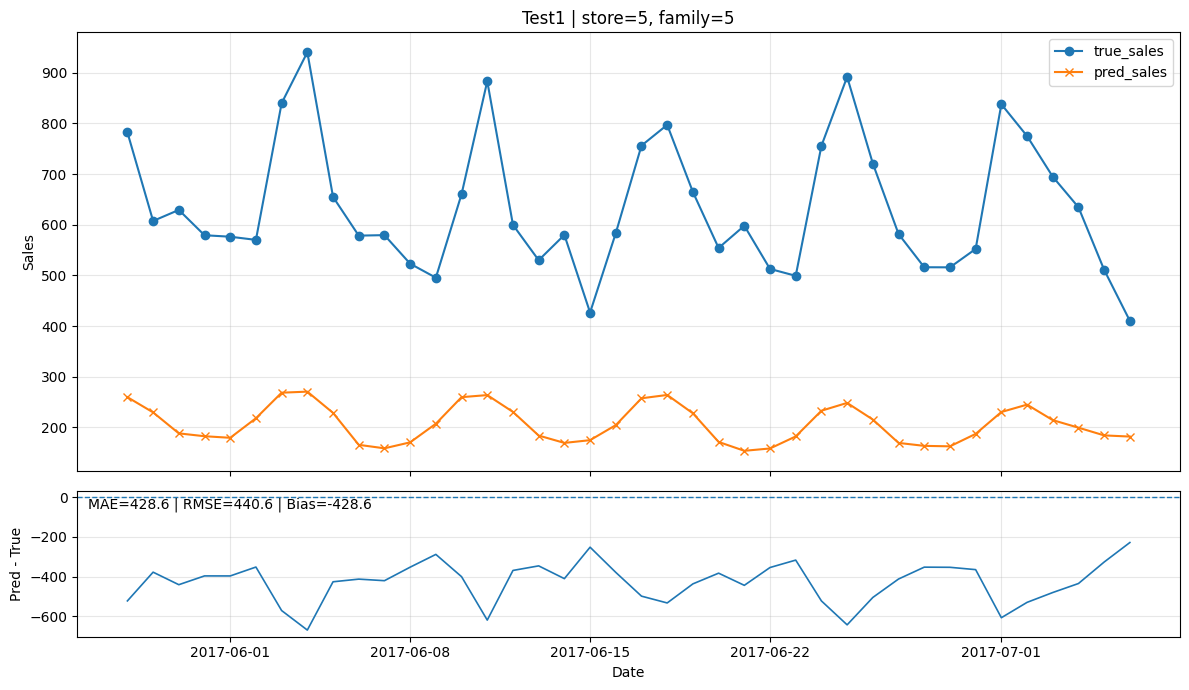

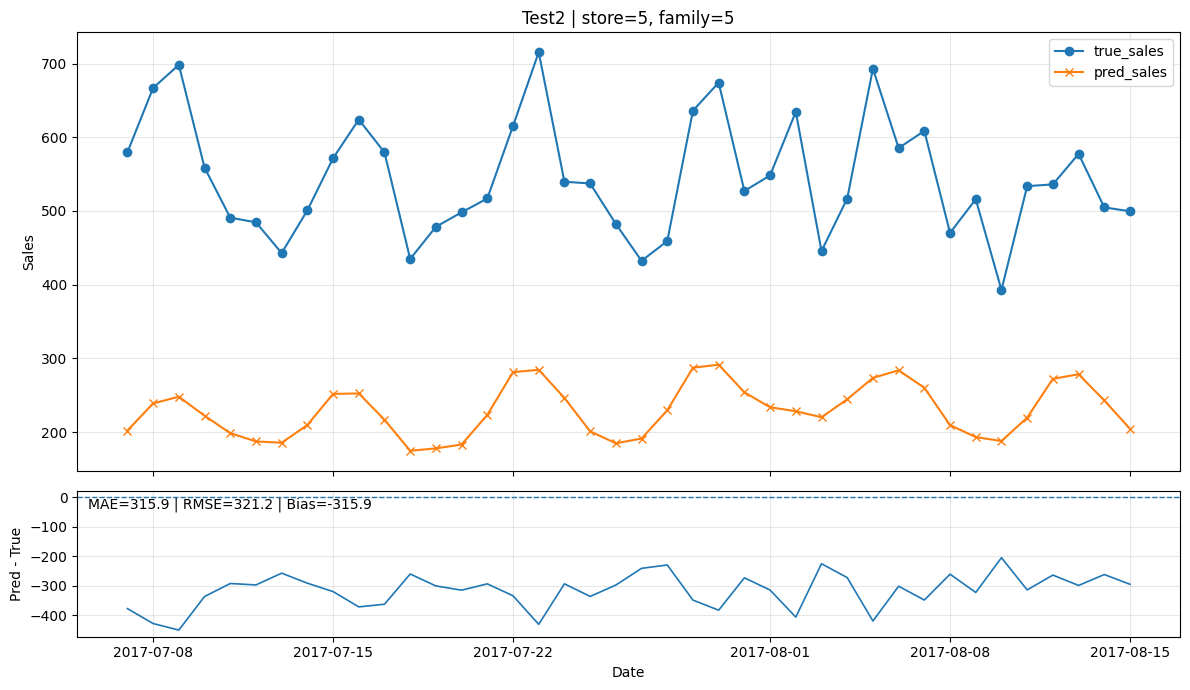

In [82]:
plot_series_compare(test1_tbl, store=5, family=5, title="Test1 | store=5, family=5")
plot_series_compare(test2_tbl, store=5, family=5, title="Test2 | store=5, family=5")

In [83]:
# Bi·ªÉu ƒë·ªì ki·ªÉm ƒë·ªãnh l·ªách (calibration) v√† ph√¢n ph·ªëi sai s·ªë
def plot_diagnostics(df, store, family, bins=30):
    d = (df[(df["store_nbr_idx"]==store) & (df["family_idx"]==family)]
           .sort_values("date").copy())
    if d.empty:
        print(f"No rows for store={store}, family={family}")
        return
    d["res"] = d["y_pred"] - d["y_true"]

    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    # Scatter true vs pred
    ax[0].scatter(d["y_true"], d["y_pred"], s=18, alpha=.7)
    lo = min(d["y_true"].min(), d["y_pred"].min())
    hi = max(d["y_true"].max(), d["y_pred"].max())
    ax[0].plot([lo,hi],[lo,hi], linestyle="--")
    ax[0].set_xlabel("True"); ax[0].set_ylabel("Pred"); ax[0].set_title("Calibration"); ax[0].grid(True, alpha=.3)

    # Histogram residuals
    ax[1].hist(d["res"], bins=bins, alpha=.9)
    ax[1].axvline(0, linestyle="--")
    ax[1].set_title("Residuals (Pred‚àíTrue)")
    ax[1].set_xlabel("Error"); ax[1].set_ylabel("Freq")
    plt.tight_layout(); plt.show()

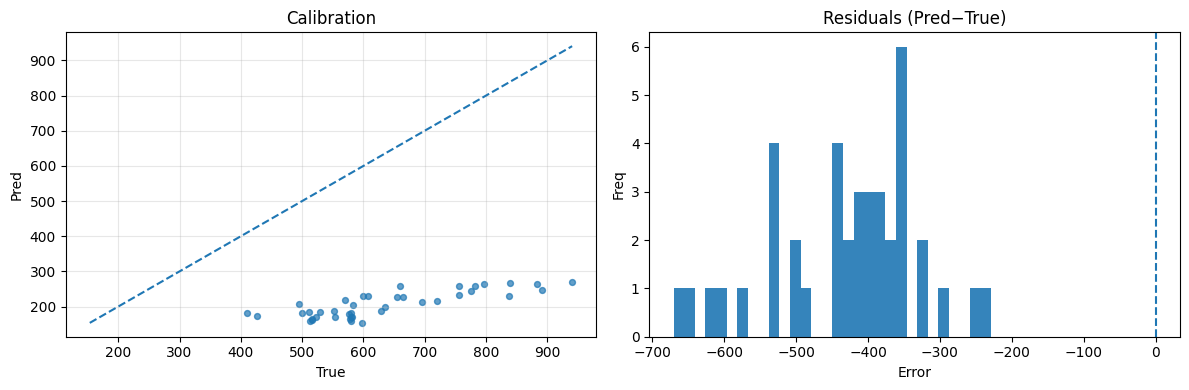

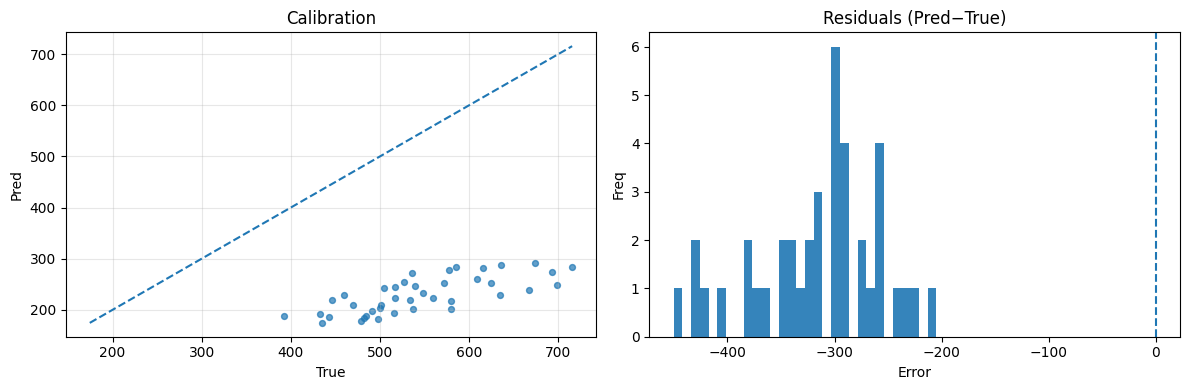

In [84]:
plot_diagnostics(test1_tbl, store=5, family=5)
plot_diagnostics(test2_tbl, store=5, family=5)


In [85]:
# 3) T·ªïng h·ª£p nhanh theo series (xem series n√†o l·ªách nh·∫•t)
def summarize_by_series(df):
    g = df.copy()
    g["res"] = g["y_pred"] - g["y_true"]
    out = (g.groupby(["store_nbr_idx","family_idx"])
             .agg(MAE=("res", lambda r: np.mean(np.abs(r))),
                  RMSE=("res", lambda r: np.sqrt(np.mean(r**2))),
                  Bias=("res", "mean"),
                  N=("res", "size"))
             .reset_index()
             .sort_values("MAE", ascending=False))
    return out

summary1 = summarize_by_series(test1_tbl)
summary2 = summarize_by_series(test2_tbl)
print(summary1.head(10))
print(summary2.head(10))

      store_nbr_idx  family_idx           MAE          RMSE          Bias   N
1464             44          12  11477.546875  12022.861328 -11477.546875  40
1530             46          12  10808.974609  11311.767578 -10808.974609  40
1497             45          12  10591.294922  11417.951172 -10591.294922  40
1431             43          12  10243.661133  10716.223633 -10243.661133  40
1422             43           3  10152.251953  10835.975586 -10152.250977  40
1455             44           3   9639.130859  10310.681641  -9639.130859  40
1449             43          30   9594.998047   9962.993164  -9594.998047  40
1521             46           3   9055.590820   9771.858398  -9055.590820  40
69                2           3   8882.861328   9290.216797  -8882.861328  40
1563             47          12   8490.007812   9285.206055  -8490.007812  40
      store_nbr_idx  family_idx           MAE          RMSE          Bias   N
1464             44          12  10564.916992  10823.375977 -105